In [1]:
import numpy as np
from dtw import *
import csv
import glob
import os
import pandas as pd
# import fastdtw
from scipy.spatial.distance import euclidean
import dtaidistance
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.signal
from scipy.interpolate import interp1d
from scipy.signal import lfilter, savgol_filter
from sklearn.preprocessing import normalize
import ruptures as rpt
import tslearn
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from dtaidistance import dtw as dtw1
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.signal import lfilter, savgol_filter
import copy
import gc
from sklearn import metrics

from sklearn.metrics import silhouette_score, pairwise_distances
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
EuclDist = scipy.spatial.distance.euclidean

from numpy import zeros
import random

from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

###################### SAX ########################
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, \
    OneD_SymbolicAggregateApproximation
from scipy.spatial.distance import cdist

# from sklearn.externals import joblib
import joblib



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

D:\Tianyu\software\anaconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
def find_dominant_arm(data):
    dominant_arm = []
    
    left_std1 = data['LeftConPosX'].std()
    left_std2 = data['LeftConPosY'].std()
    left_std3 = data['LeftConPosZ'].std()
    left_std = np.average([left_std1, left_std2, left_std3])
    right_std1 = data['RightConPosX'].std()
    right_std2 = data['RightConPosY'].std()
    right_std3 = data['RightConPosZ'].std()
    right_std = np.average([right_std1, right_std2, right_std3])
    
    if right_std >= left_std:
        # dominant_arm.append(['right',right_std,left_std])
        dominant_arm.append('right')
    else:
        # dominant_arm.append(['left',right_std,left_std])
        dominant_arm.append('left')

    del left_std1, left_std2, left_std3, left_std, right_std1, right_std2, right_std3, right_std
    gc.collect()
    return dominant_arm

In [3]:
def SG_fil(data,shi=91,order=2):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = savgol_filter(df.loc[:,n],shi,order)
    return df_new   

In [4]:
def IRR_fil(data,shi,order):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = lfilter([1.0/shi]*shi,order,df.loc[:,n])
    return df_new  

In [5]:
def moving(data, shi=100, method='wa', print_ans=False):
    df = data.copy()
    # name = df.at[30, 'Label']
    # df.drop(['Label'], axis=1, inplace=True)
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        if method == 'ewa':
            df_new[n] = df.loc[:, n].ewm(span=shi).mean()
        elif method == 'wa':
            df_new[n] = df.loc[:, n].rolling(window=shi, min_periods=1).mean()
    return df_new

In [6]:
def interpolate_data(data, arm, shi=20):
    if arm == 'right':
        data['EyePosX'][data['EyePosX']<np.min(data['RightConPosX'])] = np.nan
        data['EyePosX'][data['EyePosX']>np.max(data['RightConPosX'])] = np.nan
        data['EyePosY'][data['EyePosY']<np.min(data['RightConPosY'])] = np.nan
        data['EyePosY'][data['EyePosY']>np.max(data['RightConPosY'])] = np.nan
        data['EyePosZ'][data['EyePosZ']<np.min(data['RightConPosZ'])] = np.nan
        data['EyePosZ'][data['EyePosZ']>np.max(data['RightConPosZ'])] = np.nan
    if arm == 'left':
        data['EyePosX'][data['EyePosX']<np.min(data['LeftConPosX'])] = np.nan
        data['EyePosX'][data['EyePosX']>np.max(data['LeftConPosX'])] = np.nan
        data['EyePosY'][data['EyePosY']<np.min(data['LeftConPosY'])] = np.nan
        data['EyePosY'][data['EyePosY']>np.max(data['LeftConPosY'])] = np.nan
        data['EyePosZ'][data['EyePosZ']<np.min(data['LeftConPosZ'])] = np.nan
        data['EyePosZ'][data['EyePosZ']>np.max(data['LeftConPosZ'])] = np.nan

    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data.dropna(axis=0)
    data_m = moving(data,shi)
    # data_int = data
    # data_s = SG_fil(data,shi+1,2)
    # return data_int, data_m, data_s
    return data_m

In [6]:
path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/'
data = pd.read_csv(path + 't4_HMD.csv')
data_int, data_m, data_s = interpolate_data(data[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],'right',shi=20)
data_int.to_csv(path + 't4_int_HMD.csv')
data_s.to_csv(path + 't4_s_HMD.csv')

D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

NameError: name 'moving' is not defined

D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inp

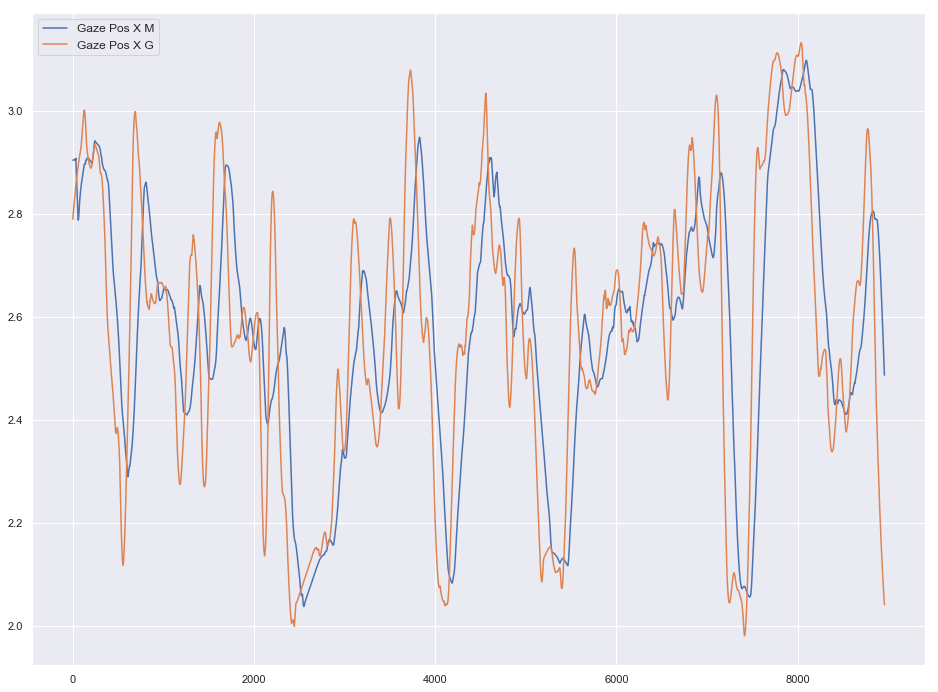

In [7]:
path_raw = 'D:/Tianyu/code/python/paper2/data/VR Perform/'
raw_data = pd.read_csv(path_raw + '10_HMD.csv')
data_int, data_m, data_s = interpolate_data(raw_data[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],'right',shi=180)
fig = plt.figure(figsize=(16, 12))
# plt.plot(data_int['EyePosX'], label='Gaze Pos X')
plt.plot(data_m['EyePosX'], label='Gaze Pos X M')
plt.plot(data_s['EyePosX'], label='Gaze Pos X G')
plt.legend(loc="best",fontsize=12)    #legend的位置左上
# print(raw_data['EyePosX'][int(50*m):int(50*(m+1))])
# print(raw_eye['EyePosX'][int(50*m):int(50*(m+1))])

In [12]:
# path = '../data/VR Perform/'
path1 = '../data/test/raw_data/'
path2 = '../data/test/label/'
path3 = '../data/test/test/'
path4 = '../data/test/all_data/'
path5 = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/predict_data/'
path = path5
data_right=[]
data_left=[]
do_arm = []
print(os.listdir(path))
for file_path in os.listdir(path):
  t=pd.read_csv(path+file_path,index_col=0)
  arm = ''.join(find_dominant_arm(t))
  do_arm.append(arm)
  t = interpolate_data(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],arm)
  t.index = range(len(t))
  t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
  # t['Label'] = os.path.basename(file_path)[:-4]  
  # t['Arm'] = arm
  if arm == 'right':
    data_right.append(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']])
  if arm == 'left':
    data_left.append(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']])

['101_HMD.csv', '102_HMD.csv']
D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [13]:
print(do_arm)

['right', 'right']


In [7]:
def get_sax(data, Magn):

    data = np.reshape(data,(1,len(data)))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
    data = scaler.fit_transform(data)

    # Magn = 2
    # n_paa_segments = 10 * Magn
    n_sax_symbols = 8 * Magn
    n_paa_segments = int(len(data[0])/20)
    # n_sax_symbols = int(n_paa_segments*0.8)

    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    paa_data = paa.inverse_transform(paa.fit_transform(data))

    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                        alphabet_size_avg=n_sax_symbols)
    sax_data = sax.inverse_transform(sax.fit_transform(data))

    # plt.plot(data[0].ravel(), "b-", alpha=0.4)
    # plt.plot(sax_data[0].ravel(), "b-",label='EyePosX')
    # plt.legend()

    del data, sax, paa
    gc.collect()
    return sax_data

In [8]:
def find_lag(data, axis, ul, arm):
    if arm == 'right':
        if axis == 'X':
            n1 = 0; n2 = 12
        if axis == 'Y':
            n1 = 1; n2 = 13
        if axis == 'Z':
            n1 = 2; n2 = 14
    if arm == 'left':
        if axis == 'X':
            n1 = 0; n2 = 9
        if axis == 'Y':
            n1 = 1; n2 = 10
        if axis == 'Z':
            n1 = 2; n2 = 11
    data1 = data[:,n1]; data2 = data[:,n2]
    dist = cdist(data1.reshape(-1,1), data2.reshape(-1,1), metric="euclidean" )
    lag = []
    dist_mean = 100
    # for i in range(len(dist)):
    for i in range(ul):
        dist_mean_new = np.mean(dist.diagonal(offset=i))
        if dist_mean_new < dist_mean:
            dist_mean = dist_mean_new
            lag = i
    del data, data1, data2, dist, dist_mean_new, dist_mean
    gc.collect()
    return lag

In [9]:
def find_sax_lag(data, axis, Magn, ul, arm):
    if arm == 'right':
        if axis == 'X':
            n1 = 0; n2 = 12
        if axis == 'Y':
            n1 = 1; n2 = 13
        if axis == 'Z':
            n1 = 2; n2 = 14
    if arm == 'left':
        if axis == 'X':
            n1 = 0; n2 = 9
        if axis == 'Y':
            n1 = 1; n2 = 10
        if axis == 'Z':
            n1 = 2; n2 = 11
    data1 = data[:,n1]; data2 = data[:,n2]
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
    data1 = scaler.fit_transform(data1.reshape(1,-1))
    data2 = scaler.fit_transform(data2.reshape(1,-1))

    n_paa_segments = int(len(data1[0])/20)
    n_sax_symbols = 8 * Magn

    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    paa_eye = paa.inverse_transform(paa.fit_transform(data1))
    paa_hand = paa.inverse_transform(paa.fit_transform(data2))
    dist_paa = cdist(paa_eye[0], paa_hand[0], metric="euclidean" )

    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                        alphabet_size_avg=n_sax_symbols)
    sax_eye = sax.inverse_transform(sax.fit_transform(data1))
    sax_hand = sax.inverse_transform(sax.fit_transform(data2))
    dist_sax = cdist(sax_eye[0], sax_hand[0], metric="euclidean" )


    lag_sax = []
    lag_paa = []
    dist_mean_sax = 100
    dist_mean_paa = 100
    for i in range(ul):
        dist_mean_new_sax = np.mean(dist_sax.diagonal(offset=i))
        dist_mean_new_paa = np.mean(dist_paa.diagonal(offset=i))
        if dist_mean_new_sax < dist_mean_sax:
            dist_mean_sax = dist_mean_new_sax
            lag_sax = i
        if dist_mean_new_paa < dist_mean_paa:
            dist_mean_paa = dist_mean_new_paa
            lag_paa = i
    del data, data1, data2, dist_sax, dist_paa, sax, sax_eye, sax_hand, paa, paa_eye, paa_hand
    gc.collect()
    return lag_sax, lag_paa

In [10]:
def interpolate_result(data,add_len):
    df = data.copy()
    x_1 = np.linspace(0, len(df[['EyePosX']]), len(df[['EyePosX']]))
    x_2 = np.linspace(0, len(df[['EyePosX']]), len(df[['EyePosX']])+add_len)
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        y_1 = df.loc[:,n]
        f = interp1d(x_1,y_1, kind='cubic')
        df_new[n] = f(x_2)
    return df_new    

In [ ]:
gazePX = []
gazePY = []
gazePZ = []
RhandPX = []
RhandPY = []
RhandPZ = []
gazeP = []
RhandP = []

gazePX_sax = []
gazePY_sax = []
gazePZ_sax = []
RhandPX_sax = []
RhandPY_sax = []
RhandPZ_sax = []
gazeP_sax = []
RhandP_sax = []

Magn = 1
for i in range(len(data)):
    gazePX.append(data[i]['EyePosX'])
    gazePY.append(data[i]['EyePosY'])
    gazePZ.append(data[i]['EyePosZ'])
    
    RhandPX.append(data[i]['RightConPosX'])
    RhandPY.append(data[i]['RightConPosY'])
    RhandPZ.append(data[i]['RightConPosZ'])

    gazeP.append(np.array([gazePX[i],gazePY[i],gazePZ[i]],dtype=float))
    RhandP.append(np.array([RhandPX[i],RhandPY[i],RhandPZ[i]],dtype=float))

    # gazePX_sax.append(get_sax(data[i]['EyePosX'].values, Magn))
    # gazePY_sax.append(get_sax(data[i]['EyePosY'].values, Magn))
    # gazePZ_sax.append(get_sax(data[i]['EyePosZ'].values, Magn))
    
    # RhandPX_sax.append(get_sax(data[i]['RightConPosX'].values, Magn))
    # RhandPY_sax.append(get_sax(data[i]['RightConPosY'].values, Magn))
    # RhandPZ_sax.append(get_sax(data[i]['RightConPosZ'].values, Magn))

    # gazeP_sax.append(np.array([gazePX_sax[i],gazePY_sax[i],gazePZ_sax[i]],dtype=float))
    # RhandP_sax.append(np.array([RhandPX_sax[i],RhandPY_sax[i],RhandPZ_sax[i]],dtype=float))

In [ ]:
alignment = dtw(gazeP[0].T, RhandP[0].T, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))
# alignment = dtw(gazeP_sax[0][0][0], RhandP_sax[0][0][0], keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))
alignment.plot(type="threeway",figsize=(8,8))

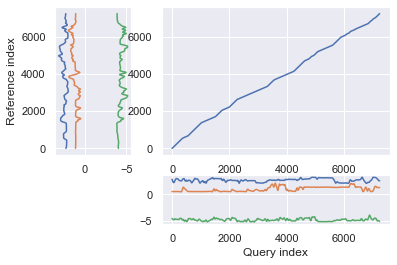

<AxesSubplot:>

In [30]:
# alignment = dtw(data[0][:,0:3], data[0][:,12:15], keep_internals=True, 
alignment = dtw(data_right[0][['EyePosX','EyePosY','EyePosZ']], data_right[0][['RightConPosX','RightConPosY','RightConPosZ']], keep_internals=True, 
step_pattern=rabinerJuangStepPattern(6, "c"))
alignment.plot(type="threeway",figsize=(8,8))

In [18]:
x_right = []
x_left = []
y_right = []
y_left = []
for i in range(len(data_right)):
    alignment = dtw(data_right[i][['EyePosX','EyePosY','EyePosZ']], data_right[i][['RightConPosX','RightConPosY','RightConPosZ']], keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))
    x_right.append(alignment.index1s)
    y_right.append(alignment.index2s)
    del alignment
    gc.collect()
for i in range(len(data_left)):
    alignment = dtw(data_left[i][['EyePosX','EyePosY','EyePosZ']], data_left[i][['LeftConPosX','LeftConPosY','LeftConPosZ']], keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))
    x_left.append(alignment.index1s)
    y_left.append(alignment.index2s)
    del alignment
    gc.collect()

In [19]:
x_new_right = []
x_new_left = []
y_new_right = []
y_new_left = []
for i in range(len(data_right)):
# for i in range(1):
    x_new_right_array = []
    y_new_right_array = []
    for j in range(len(x_right[i])-1):
        if x_right[i][j+1]!=x_right[i][j]:
            x_new_right_array.append(x_right[i][j+1])
            y_new_right_array.append(y_right[i][j+1])
    x_new_right.append(x_new_right_array)
    y_new_right.append(y_new_right_array)
for i in range(len(data_left)):
    x_new_left_array = []
    y_new_left_array = []
    for j in range(len(x_left[i])-1):
        if x_left[i][j+1]!=x_left[i][j]:
            x_new_left_array.append(x_left[i][j+1])
            y_new_left_array.append(y_left[i][j+1])
    x_new_left.append(x_new_left_array)
    y_new_left.append(y_new_left_array)

In [ ]:
    np.save(path + 'shift_right.npy',shift_right)
    np.save(path + 'shift_left.npy',shift_left)

In [12]:
path5 = 'D:/Tianyu/code/python/paper2/data/test/result/label_all_01192021/parameter/'
path6 = 'D:/Tianyu/code/python/paper2/data/test/result/label_all_01192021/parameter_whole/'
# path5 = '../data/test/result/label_all_1122/training/'
# path6 = '../data/test/result/label_all_1122/prediction/'
# path7 = '../data/test/result/label_all_1122/training1/'
path = path5
if 0:
    np.save(path + 'x_right.npy',x_right)
    np.save(path + 'x_left.npy',x_left)
    np.save(path + 'y_right.npy',y_right)
    np.save(path + 'y_left.npy',y_left)
    np.save(path + 'x_new_right.npy',x_new_right)
    np.save(path + 'x_new_left.npy',x_new_left)
    np.save(path + 'y_new_right.npy',y_new_right)
    np.save(path + 'y_new_left.npy',y_new_left)

    np.save(path + 'result_right.npy',result_right)
    np.save(path + 'result_left.npy',result_left)
    np.save(path + 'result_new_right.npy',result_new_right)
    np.save(path + 'result_new_left.npy',result_new_left)
    np.save(path + 'lag_sax_array_right.npy',lag_sax_array_right)
    np.save(path + 'lag_sax_array_left.npy',lag_sax_array_left)
    np.save(path + 'labels_right.npy',labels_right)
    np.save(path + 'labels_left.npy',labels_left)
    np.save(path + 'shift_right.npy',shift_right)
    np.save(path + 'shift_left.npy',shift_left)
if 1:
    data_right = np.load(path + 'data_right.npy',allow_pickle=True)
    data_left = np.load(path + 'data_left.npy',allow_pickle=True)
    x_right = np.load(path + 'x_right.npy',allow_pickle=True)
    x_left = np.load(path + 'x_left.npy',allow_pickle=True)
    y_right = np.load(path + 'y_right.npy',allow_pickle=True)
    y_left = np.load(path + 'y_left.npy',allow_pickle=True)
    x_new_right = np.load(path + 'x_new_right.npy',allow_pickle=True)
    x_new_left = np.load(path + 'x_new_left.npy',allow_pickle=True)
    y_new_right = np.load(path + 'y_new_right.npy',allow_pickle=True)
    y_new_left = np.load(path + 'y_new_left.npy',allow_pickle=True)

    result_right = np.load(path + 'result_right.npy',allow_pickle=True)
    result_left = np.load(path + 'result_left.npy',allow_pickle=True)
    result_new_right = np.load(path + 'result_new_right.npy',allow_pickle=True)
    result_new_left = np.load(path + 'result_new_left.npy',allow_pickle=True)
    lag_sax_array_right = np.load(path + 'lag_sax_array_right.npy',allow_pickle=True)
    lag_sax_array_left = np.load(path + 'lag_sax_array_left.npy',allow_pickle=True)
    labels_right = np.load(path + 'labels_right.npy',allow_pickle=True)
    labels_left = np.load(path + 'labels_left.npy',allow_pickle=True)
    shift_right = np.load(path + 'shift_right.npy',allow_pickle=True)
    shift_left = np.load(path + 'shift_left.npy',allow_pickle=True)

In [19]:
path = path6
# lag_sax_array_right = np.load(path + 'lag_sax_array_right.npy',allow_pickle=True)
# lag_sax_array_left = np.load(path + 'lag_sax_array_left.npy',allow_pickle=True)

np.save(path + 'labels_right.npy',labels_right)
np.save(path + 'labels_left.npy',labels_left)

In [18]:
print(data_right[0])

       EyePosX   EyePosY   EyePosZ  GazePosX  GazePosY  GazePosZ  CameraPosX  \
0     2.822504  0.514244 -4.541595  2.786094  0.677513 -4.973050    2.410999   
1     2.801032  0.514733 -4.549746  2.782871  0.670831 -4.982687    2.410421   
2     2.779957  0.515210 -4.557744  2.779651  0.664268 -4.992159    2.409845   
3     2.759281  0.515674 -4.565590  2.776433  0.657824 -5.001467    2.409270   
4     2.739002  0.516125 -4.573283  2.773217  0.651500 -5.010612    2.408695   
...        ...       ...       ...       ...       ...       ...         ...   
7233  2.547954  1.280283 -5.066378  2.393655  1.578160 -4.335820    2.476668   
7234  2.548260  1.282040 -5.070373  2.375240  1.584458 -4.156173    2.476487   
7235  2.548698  1.283851 -5.074435  2.357061  1.590866 -3.974052    2.476307   
7236  2.549267  1.285717 -5.078565  2.339118  1.597384 -3.789458    2.476127   
7237  2.549967  1.287637 -5.082763  2.321410  1.604013 -3.602389    2.475947   

      CameraPosY  CameraPosZ  LeftConPo

In [ ]:
    # new filtered data
    path = 'D:/Tianyu/code/python/paper2/data/test/result/label_all_01192021/parameter/'
    data_right = np.load(path + 'data_right.npy',allow_pickle=True)
    data_left = np.load(path + 'data_left.npy',allow_pickle=True)
    x_right = np.load(path + 'x_right.npy',allow_pickle=True)
    x_left = np.load(path + 'x_left.npy',allow_pickle=True)
    y_right = np.load(path + 'y_right.npy',allow_pickle=True)
    y_left = np.load(path + 'y_left.npy',allow_pickle=True)
    x_new_right = np.load(path + 'x_new_right.npy',allow_pickle=True)
    x_new_left = np.load(path + 'x_new_left.npy',allow_pickle=True)
    y_new_right = np.load(path + 'y_new_right.npy',allow_pickle=True)
    y_new_left = np.load(path + 'y_new_left.npy',allow_pickle=True)

    result_right = np.load(path + 'result_right.npy',allow_pickle=True)
    result_left = np.load(path + 'result_left.npy',allow_pickle=True)
    result_new_right = np.load(path + 'result_new_right.npy',allow_pickle=True)
    result_new_left = np.load(path + 'result_new_left.npy',allow_pickle=True)
    lag_sax_array_right = np.load(path + 'lag_sax_array_right.npy',allow_pickle=True)
    lag_sax_array_left = np.load(path + 'lag_sax_array_left.npy',allow_pickle=True)
    labels_right = np.load(path + 'labels_right.npy',allow_pickle=True)
    labels_left = np.load(path + 'labels_left.npy',allow_pickle=True)
    # shift_right = np.load(path + 'shift_right.npy',allow_pickle=True)
    # shift_left = np.load(path + 'shift_left.npy',allow_pickle=True)

In [36]:
lag_sax_array_right[:,30:40]

array([[299, 140, 260, 180,  80, 260, 240,  20,   0,  40],
       [240,  20,  80,  80,  20, 265, 299,  60,  40,  80],
       [299, 260, 220, 299, 299, 140, 299, 299, 100, 260]])

907

In [22]:
result_right = []
result_left = []
for i in range(len(data_right)):
    algo = rpt.Pelt(model="rbf", min_size=300).fit(np.array(y_new_right[i]))
    result_right.append(algo.predict(pen=3))
    result_right[i] = np.concatenate(([0],result_right[i]))
for i in range(len(data_left)):
    algo = rpt.Pelt(model="rbf", min_size=300).fit(np.array(y_new_left[i]))
    result_left.append(algo.predict(pen=3))
    result_left[i] = np.concatenate(([0],result_left[i]))

In [ ]:
n = 0
algo = rpt.Pelt(model="rbf", min_size=300).fit(np.array(y_new_right[n]))
result_test = algo.predict(pen=3)
rpt.display(np.array(y_new_right[n]), result_test,figsize=(8,8))
plt.show()

In [23]:
result_new_right = []
for i in range(len(result_right)):
    result_new_right_array = []
    for j in range(len(result_right[i])-1):
        pos_1 = x_new_right[i].index(result_right[i][j]+1)
        pos_2 = x_new_right[i].index(result_right[i][j+1])
        x_min = np.min((x_new_right[i][pos_1],y_new_right[i][pos_1]))-1
        x_max = np.max((x_new_right[i][pos_2],y_new_right[i][pos_2])) 
        result_new_right_array.append([x_min,x_max])
    result_new_right.append(result_new_right_array)
result_new_right = np.array(result_new_right)

result_new_left = []
for i in range(len(result_left)):
    result_new_left_array = []
    for j in range(len(result_left[i])-1):
        pos_1 = x_new_left[i].index(result_left[i][j]+1)
        pos_2 = x_new_left[i].index(result_left[i][j+1])
        x_min = np.min((x_new_left[i][pos_1],y_new_left[i][pos_1]))-1
        x_max = np.max((x_new_left[i][pos_2],y_new_left[i][pos_2])) 
        result_new_left_array.append([x_min,x_max])
    result_new_left.append(result_new_left_array)
result_new_left = np.array(result_new_left)

ipykernel_launcher:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
n = 0
Magn = 1
ul = 300

lag_array_right = []
lag_sax_array_right = []
lag_sax_array_x_right = []
lag_sax_array_y_right = []
lag_sax_array_z_right = []
avg_dis_array_right = []
for i in range(len(data_right)):
  n = n + len(result_new_right[i])
  print('n:')
  print(n)
  for j in range(n-len(result_new_right[i]),n):
    lag = []
    lag_sax = []
    dataset = []
    print('j:')
    print(j)
    dataset = np.array(data_right[i][result_new_right[i][j+len(result_new_right[i])-n][0]:result_new_right[i][j+len(result_new_right[i])-n][1]])
    # lag = find_lag(dataset, axis, ul)
    # lag_array_right.append(lag)    
    lag_sax_x_right, lag_paa_x_right= find_sax_lag(dataset, 'X', Magn, ul)
    lag_sax_array_x_right.append(lag_sax_x_right)
    lag_sax_y_right, lag_paa_y_right= find_sax_lag(dataset, 'Y', Magn, ul)
    lag_sax_array_y_right.append(lag_sax_y_right)
    lag_sax_z_right, lag_paa_z_right= find_sax_lag(dataset, 'Z', Magn, ul)
    lag_sax_array_z_right.append(lag_sax_z_right)

lag_sax_array_right = [lag_sax_array_x_right,lag_sax_array_y_right,lag_sax_array_z_right]
lag_sax_array_right = np.array(lag_sax_array_right)

lag_array_left = []
lag_sax_array_left = []
lag_sax_array_x_left = []
lag_sax_array_y_left = []
lag_sax_array_z_left = []
avg_dis_array_left = []
for i in range(len(data_left)):
  n = n + len(result_new_left[i])
  print('n:')
  print(n)
  for j in range(n-len(result_new_left[i]),n):
    lag = []
    lag_sax = []
    dataset = []
    print('j:')
    print(j)
    dataset = np.array(data_left[i][result_new_left[i][j+len(result_new_left[i])-n][0]:result_new_left[i][j+len(result_new_left[i])-n][1]])
    # lag = find_lag(dataset, axis, ul)
    # lag_array_left.append(lag)    
    lag_sax_x_left, lag_paa_x_left= find_sax_lag(dataset, 'X', Magn, ul)
    lag_sax_array_x_left.append(lag_sax_x_left)
    lag_sax_y_left, lag_paa_y_left= find_sax_lag(dataset, 'Y', Magn, ul)
    lag_sax_array_y_left.append(lag_sax_y_left)
    lag_sax_z_left, lag_paa_z_left= find_sax_lag(dataset, 'Z', Magn, ul)
    lag_sax_array_z_left.append(lag_sax_z_left)

lag_sax_array_left = [lag_sax_array_x_left,lag_sax_array_y_left,lag_sax_array_z_left]
lag_sax_array_left = np.array(lag_sax_array_left)

In [20]:
len(data_right[2])

4734

In [23]:
############## whole human #########################
n = 0
Magn = 1
ul = 300

lag_array_right = []
lag_sax_array_right = []
lag_sax_array_x_right = []
lag_sax_array_y_right = []
lag_sax_array_z_right = []
avg_dis_array_right = []
for i in range(len(data_right)):
    print('i:')
    print(i)

    arm = 'right'
    lag = []
    lag_sax = []
    dataset = []
    dataset = np.array(data_right[i])
    # lag = find_lag(dataset, axis, ul)
    # lag_array_right.append(lag)    
    lag_sax_x_right, lag_paa_x_right= find_sax_lag(dataset, 'X', Magn, ul, arm)
    lag_sax_array_x_right.append(lag_sax_x_right)
    lag_sax_y_right, lag_paa_y_right= find_sax_lag(dataset, 'Y', Magn, ul, arm)
    lag_sax_array_y_right.append(lag_sax_y_right)
    lag_sax_z_right, lag_paa_z_right= find_sax_lag(dataset, 'Z', Magn, ul, arm)
    lag_sax_array_z_right.append(lag_sax_z_right)

lag_sax_array_right = [lag_sax_array_x_right,lag_sax_array_y_right,lag_sax_array_z_right]
lag_sax_array_right = np.array(lag_sax_array_right)

lag_array_left = []
lag_sax_array_left = []
lag_sax_array_x_left = []
lag_sax_array_y_left = []
lag_sax_array_z_left = []
avg_dis_array_left = []
for i in range(len(data_left)):
    print('i:')
    print(i)

    arm = 'left'
    lag = []
    lag_sax = []
    dataset = []
    dataset = np.array(data_left[i])
    # lag = find_lag(dataset, axis, ul)
    # lag_array_left.append(lag)    
    lag_sax_x_left, lag_paa_x_left= find_sax_lag(dataset, 'X', Magn, ul, arm)
    lag_sax_array_x_left.append(lag_sax_x_left)
    lag_sax_y_left, lag_paa_y_left= find_sax_lag(dataset, 'Y', Magn, ul, arm)
    lag_sax_array_y_left.append(lag_sax_y_left)
    lag_sax_z_left, lag_paa_z_left= find_sax_lag(dataset, 'Z', Magn, ul, arm)
    lag_sax_array_z_left.append(lag_sax_z_left)

lag_sax_array_left = [lag_sax_array_x_left,lag_sax_array_y_left,lag_sax_array_z_left]
lag_sax_array_left = np.array(lag_sax_array_left)


i:
0
i:
1
i:
2
i:
3
i:
4
i:
5
i:
6
i:
7
i:
8
i:
9
i:
10
i:
11
i:
12
i:
13
i:
14
i:
15
i:
16
i:
17
i:
18
i:
19
i:
20
i:
21
i:
22
i:
23
i:
24
i:
25
i:
26
i:
27
i:
28
i:
29
i:
30
i:
31
i:
32
i:
33
i:
34
i:
35
i:
36
i:
37
i:
38
i:
39
i:
40
i:
41
i:
42
i:
43
i:
44
i:
45
i:
46
i:
47
i:
48
i:
49
i:
50
i:
51
i:
52
i:
53
i:
54
i:
55
i:
56
i:
57
i:
58
i:
59
i:
60
i:
61
i:
62
i:
0
i:
1
i:
2
i:
3
i:
4
i:
5
i:
6
i:
7
i:
8
i:
9
i:
10
i:
11
i:
12
i:
13
i:
14
i:
15
i:
16
i:
17
i:
18
i:
19
i:
20
i:
21
i:
22
i:
23
i:
24
i:
25
i:
26
i:
27
i:
28
i:
29
i:
30
i:
31
i:
32
i:
33
i:
34
i:
35


In [14]:
print(lag_sax_array_right)
print(lag_sax_array_left)

[[ 60 140  20  40  60  40  60  60  60  40  75  40  40 100 100 100  80 100
   40  60  80  80  40  80 100  60  80  60 120  40  40  80  80  60  40  80
   20  40 120   0  60  40  80  80  60  40 100  40  60  20  40 140  40  80
   80  40 140  40  60  60  60  80  40]
 [  0  60  80 280  84  60  80 140  38  40 100  50  20  30  80 120  40  20
   80  80 120  80  40 100  40  80 120  60  80  80  40  80  60   0  40 140
    0  20 100  20  60  52  60 299   0  60  40 120  40 299  40  20  20  40
  180  40 100  40  40   0 120  40  40]
 [299   0 299 299   0  60 120   0  40   0 120   0 120 260  80 200 180  26
  240 299   0 280 299  80 140   0 299   0 160 140 100   0  20 299 120 140
  299  80 120  20  60  40 220 260   0   0 280 299  60 120 140 289   0 140
  299 140 260  60   0 299 220 160   0]]
[[100 100  40  40  60 220 180  40  40  60  40 100  40  80  80 160  60  40
  120  60  40  40  74  40  60 140 100  40  80 100 100  40  80  60 100  80]
 [160  40  60 220 120   0 100  20 100  40  40   0  40  60 260 299  

In [37]:
path = 'D:/Tianyu/code/python/paper2/data/test/result/label_all_01192021/parameter_whole/'
np.save(path + 'lag_sax_array_right.npy',lag_sax_array_right)
np.save(path + 'lag_sax_array_left.npy',lag_sax_array_left)

In [41]:
# path = path5
n_clus = 3
# dis_kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(avg_dis_array).reshape(-1,1))
# sax_kmeans = KMeans(n_clusters=6, random_state=0).fit(np.array(lag_sax_array_x).reshape(-1,1))
sax_kmeans_right = KMeans(n_clusters=n_clus, random_state=0).fit(np.array(lag_sax_array_right).T)
sax_kmeans_left = KMeans(n_clusters=n_clus, random_state=0).fit(np.array(lag_sax_array_left).T)
# sax_kmeans = KMeans(n_clusters=6, random_state=0).fit(np.array([lag_sax_array_x,lag_sax_array_y]).T)
# dis_labels = dis_kmeans.labels_
sax_labels_right = sax_kmeans_right.labels_
sax_labels_left = sax_kmeans_left.labels_
labels_right = sax_labels_right
labels_left = sax_labels_left

# joblib.dump(sax_kmeans_right, path + 'sax_kmeans_right.pkl')
# joblib.dump(sax_kmeans_left, path + 'sax_kmeans_left.pkl')
# test_model = joblib.load(path + 'sax_kmeans.pkl') 
print(labels_right)
print(labels_left)

[1 0 1 2 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 1 2 0 0 1 1 0 2 0 1 0 0 2 0 1 0 0 1 1 0 0]
[0 0 1 2 0 0 1 0 1 1 0 0 0 0 2 2 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0]


In [17]:
labels_right = [1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,2,0,0,1,1,0,2,0,1,0,0,2,0,1,0,0,1,1,0,0]
labels_left = [0,0,1,2,0,0,1,0,1,1,0,0,0,0,2,2,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0]

In [36]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 20  # mpl模块载入的时候加载配置信息存储在rcParams变量中，rc_params_from_file()函数从文件加载配置信息
font = {
    'color': 'b',
    'style': 'oblique',
    'size': 20,
    'weight': 'bold'
}

In [42]:
left_1x,left_2x,left_3x,left_4x,left_5x,left_6x,left_7x,left_8x = [],[],[],[],[],[],[],[]
left_1y,left_2y,left_3y,left_4y,left_5y,left_6y,left_7y,left_8y = [],[],[],[],[],[],[],[]
left_1z,left_2z,left_3z,left_4z,left_5z,left_6z,left_7z,left_8z = [],[],[],[],[],[],[],[]
right_1x,right_2x,right_3x,right_4x,right_5x,right_6x,right_7x,right_8x = [],[],[],[],[],[],[],[]
right_1y,right_2y,right_3y,right_4y,right_5y,right_6y,right_7y,right_8y = [],[],[],[],[],[],[],[]
right_1z,right_2z,right_3z,right_4z,right_5z,right_6z,right_7z,right_8z = [],[],[],[],[],[],[],[]
for i in range(len(labels_left)):
    if labels_left[i] == 0:
        left_1x.append(lag_sax_array_left[0][i]),left_1y.append(lag_sax_array_left[1][i]),left_1z.append(lag_sax_array_left[2][i])
    if labels_left[i] == 1:
        left_2x.append(lag_sax_array_left[0][i]),left_2y.append(lag_sax_array_left[1][i]),left_2z.append(lag_sax_array_left[2][i])
    if labels_left[i] == 2:
        left_3x.append(lag_sax_array_left[0][i]),left_3y.append(lag_sax_array_left[1][i]),left_3z.append(lag_sax_array_left[2][i])
    # if labels_left[i] == 3:
    #     left_4x.append(lag_sax_array_left[0][i]),left_4y.append(lag_sax_array_left[1][i]),left_4z.append(lag_sax_array_left[2][i])
    # if labels_left[i] == 4:
    #     left_5x.append(lag_sax_array_left[0][i]),left_5y.append(lag_sax_array_left[1][i]),left_5z.append(lag_sax_array_left[2][i])
    # if labels_left[i] == 5:
    #     left_6x.append(lag_sax_array_left[0][i]),left_6y.append(lag_sax_array_left[1][i]),left_6z.append(lag_sax_array_left[2][i])
    # if labels_left[i] == 6:
    #     left_7x.append(lag_sax_array_left[0][i]),left_7y.append(lag_sax_array_left[1][i]),left_7z.append(lag_sax_array_left[2][i])
    # if labels_left[i] == 7:
    #     left_8x.append(lag_sax_array_left[0][i]),left_8y.append(lag_sax_array_left[1][i]),left_8z.append(lag_sax_array_left[2][i])

for i in range(len(labels_right)):
    if labels_right[i] == 0:
        right_1x.append(lag_sax_array_right[0][i]),right_1y.append(lag_sax_array_right[1][i]),right_1z.append(lag_sax_array_right[2][i])
    if labels_right[i] == 1:
        right_2x.append(lag_sax_array_right[0][i]),right_2y.append(lag_sax_array_right[1][i]),right_2z.append(lag_sax_array_right[2][i])
    if labels_right[i] == 2:
        right_3x.append(lag_sax_array_right[0][i]),right_3y.append(lag_sax_array_right[1][i]),right_3z.append(lag_sax_array_right[2][i])
    # if labels_right[i] == 3:
    #     right_4x.append(lag_sax_array_right[0][i]),right_4y.append(lag_sax_array_right[1][i]),right_4z.append(lag_sax_array_right[2][i])
    # if labels_right[i] == 4:
    #     right_5x.append(lag_sax_array_right[0][i]),right_5y.append(lag_sax_array_right[1][i]),right_5z.append(lag_sax_array_right[2][i])
    # if labels_right[i] == 5:
    #     right_6x.append(lag_sax_array_right[0][i]),right_6y.append(lag_sax_array_right[1][i]),right_6z.append(lag_sax_array_right[2][i])
    # if labels_right[i] == 6:
    #     right_7x.append(lag_sax_array_right[0][i]),right_7y.append(lag_sax_array_right[1][i]),right_7z.append(lag_sax_array_right[2][i])
    # if labels_right[i] == 7:
    #     right_8x.append(lag_sax_array_right[0][i]),right_8y.append(lag_sax_array_right[1][i]),right_8z.append(lag_sax_array_right[2][i])


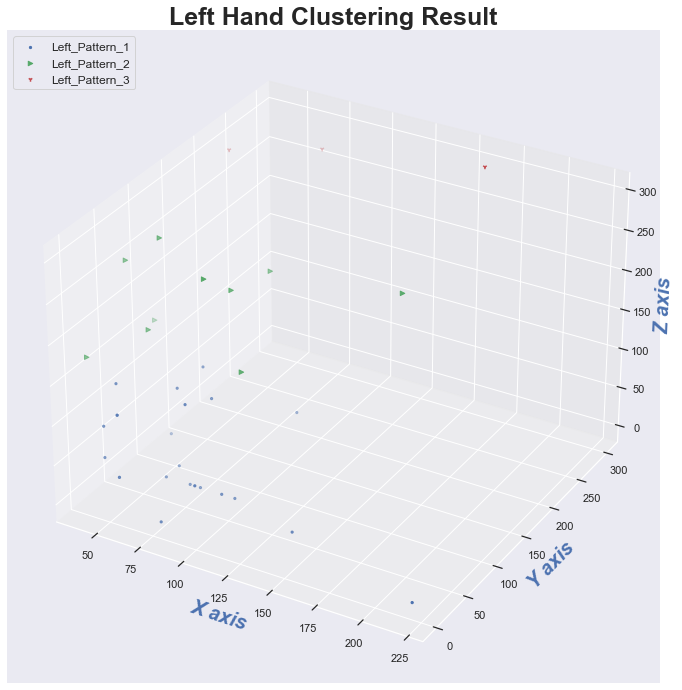

In [45]:
fig = plt.figure(figsize=(12, 12))  #参数为图片大小
ax = fig.gca(projection='3d')  # get current axes，且坐标轴是3d的
ax.set_aspect('auto')  # 坐标轴间比例一致

ax.scatter(left_1x,left_1y,left_1z,c='b',marker='.',label='Left_Pattern_1')
ax.scatter(left_2x,left_2y,left_2z,c='g',marker='>',label='Left_Pattern_2')
ax.scatter(left_3x,left_3y,left_3z,c='r',marker='1',label='Left_Pattern_3')
# ax.scatter(left_4x,left_4y,left_4z,c='c',marker='s',label='Left_Pattern_4')
# ax.scatter(left_5x,left_5y,left_5z,c='m',marker='p',label='Left_Pattern_5')
# ax.scatter(left_6x,left_6y,left_6z,c='y',marker='*',label='Left_Pattern_6')
# ax.scatter(left_7x,left_7y,left_7z,c='k',marker='x',label='Left_Pattern_7')
# ax.scatter(left_8x,left_8y,left_8z,c='OrangeRed',marker='|',label='Left_Pattern_8')

ax.set_xlabel("X axis",fontdict=font)
ax.set_ylabel("Y axis",fontdict=font)
ax.set_zlabel("Z axis",fontdict=font)
ax.set_title("Left Hand Clustering Result", size=25, weight='bold')   #子图的title
ax.legend(loc="upper left",fontsize=12)    #legend的位置左上
# ax.legend(loc="best",fontsize=12)    #legend的位置左上

plt.show()

In [49]:
fig = plt.figure(figsize=(12, 12))  #参数为图片大小
ax = fig.gca(projection='3d')  # get current axes，且坐标轴是3d的
ax.set_aspect('equal')  # 坐标轴间比例一致

ax.scatter(right_1x,right_1y,right_1z,c='b',marker='.',label='Right_Pattern_1')
ax.scatter(right_2x,right_2y,right_2z,c='g',marker='>',label='Right_Pattern_2')
ax.scatter(right_3x,right_3y,right_3z,c='r',marker='1',label='Right_Pattern_3')
# ax.scatter(right_4x,right_4y,right_4z,c='c',marker='s',label='Right_Pattern_4')
# ax.scatter(right_5x,right_5y,right_5z,c='m',marker='p',label='Right_Pattern_5')
# ax.scatter(right_6x,right_6y,right_6z,c='y',marker='*',label='Right_Pattern_6')
# ax.scatter(right_7x,right_7y,right_7z,c='k',marker='x',label='Right_Pattern_7')
# ax.scatter(right_8x,right_8y,right_8z,c='OrangeRed',marker='|',label='Right_Pattern_8')

ax.set_xlabel("X axis",fontdict=font)
ax.set_ylabel("Y axis",fontdict=font)
ax.set_zlabel("Z axis",fontdict=font)
ax.set_title("Right Hand Clustering Result", size=25, weight='bold')
ax.legend(loc="upper left",fontsize=12)    #legend的位置左上
# ax.legend(loc="best",fontsize=12)    #legend的位置左上

plt.show()

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

In [20]:
 import matplotlib
 matplotlib.__version__

'3.3.4'

In [ ]:
def smooth_result(path_r, path_m_out, path_r_out, shi=270):
    result_old = pd.read_csv(path_r)
    result_old = result_old[180:-1].reset_index()
    result_new = SG_fil(result_old[['PosX','PosY','PosZ']],shi=shi+1,order=1)
    result_new['PosX_original'] = result_old['PosX_original']
    result_new['PosY_original'] = result_old['PosY_original']
    result_new['PosZ_original'] = result_old['PosZ_original']
    result_new['EyePosX'] = result_old['EyePosX']
    result_new['EyePosY'] = result_old['EyePosY']
    result_new['EyePosZ'] = result_old['EyePosZ']
    result_new['DiffX'] = abs(result_new['PosX'] - result_new['PosX_original'])
    result_new['DiffY'] = abs(result_new['PosY'] - result_new['PosY_original'])
    result_new['DiffZ'] = abs(result_new['PosZ'] - result_new['PosZ_original'])
    result_new.reset_index(drop=True, inplace=True)
        
    mae_x, r2_x = [], []
    mae_y, r2_y = [], []
    mae_z, r2_z = [], []
    for s in ['PosX', 'PosY', 'PosZ']:
        if s == 'PosX':
            mae_x.append(metrics.mean_absolute_error(result_new[s + '_original'], result_new[s]))
            r2_x.append(metrics.r2_score(result_new[s + '_original'], result_new[s]))
        elif s == 'PosY':
            mae_y.append(metrics.mean_absolute_error(result_new[s + '_original'], result_new[s]))
            r2_y.append(metrics.r2_score(result_new[s + '_original'], result_new[s]))
        else:
            mae_z.append(metrics.mean_absolute_error(result_new[s + '_original'], result_new[s]))
            r2_z.append(metrics.r2_score(result_new[s + '_original'], result_new[s]))
    
    metric_data = {
    'temp_mae_x': mae_x,
    'temp_mae_y': mae_y,
    'temp_mae_z': mae_z,
    'temp_r2_x': r2_x,
    'temp_r2_y': r2_y,
    'temp_r2_z': r2_z
    }
    metric_result = pd.DataFrame(metric_data)
    metric_result.to_csv(path_m_out)
    result_new.to_csv(path_r_out)

    return result_new  

In [ ]:
change = 'not_change_gbm/'
path_ori = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/predict/' + change
# path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/pinjie/'
path_smo = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/predict_smooth/' + change
# path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/pinjie_smooth/'
# path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/weipinjie/'
# cluster = 'left'
# hand = 'all'
# path_r = path_smo + 'result_label_' + cluster + '_' + hand + '.csv'
# path_m = path_smo + 'result_metric_' + cluster + '_' + hand + '.csv'
people = '101'
path_r = path_ori + 'result_' + people + '_HMD.csv'
path_m_out = path_smo + 'result_metric_' + people + '_HMD.csv'
path_r_out = path_smo + 'result_' + people + '_HMD.csv'
smooth_result(path_r, path_m_out, path_r_out, shi=270)
# metric = pd.read_csv(path + 'result_metric_' + cluster + '_' + hand + '.csv')
metric = pd.read_csv(path_m_out)
print(metric)
# for hand in ['right','left']:
    # for cluster in ['1','2','3','4','5','6','7','8']:
    #     result_new = smooth_result(path, cluster, hand, shi=270)
    #     metric = pd.read_csv(path + 'result_metric_' + cluster + '_' + hand + '.csv')
    #     print(metric)
# for people in ['101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120']:
#     path_r = path_ori + 'result_' + people + '_HMD.csv'
#     path_m_out = path_smo + 'result_metric_' + people + '_HMD.csv'
#     path_r_out = path_smo + 'result_' + people + '_HMD.csv'
#     smooth_result(path_r, path_m_out, path_r_out, shi=270)
#     metric = pd.read_csv(path_m_out)
#     print(metric)


In [ ]:
if 0:
    m = 10.5
    path_raw = 'D:/Tianyu/code/python/paper2/data/VR Perform/'
    raw_data = pd.read_csv(path_raw + '100_HMD.csv')
    raw_eye = interpolate_data(raw_data[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],'right',shi=60)
    # raw_eye = moving(raw_data[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],shi=100)
    plt.plot(raw_data['EyePosX'], label='Gaze Pos X')
    plt.plot(raw_eye['EyePosX'], label='Gaze Pos X')
    # print(raw_data['EyePosX'][int(50*m):int(50*(m+1))])
    # print(raw_eye['EyePosX'][int(50*m):int(50*(m+1))])
if 1:
    # result = 'pinjie_smooth/'
    # path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/' + result
    # cluster = 'right'
    # hand = 'all'
    # axis = 'X'
    # draw = pd.read_csv(path + 'result_label_' + cluster + '_' + hand + '.csv')
    
    # result = 'predict/'
    change = 'not_change_gbm/'
    # result = 'predict/'
    result = 'predict_smooth/'
    path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/' + result + change
    people = '114'
    for people in ['101','102','103','104','105','106','107']:
        axis = 'X'
        draw = pd.read_csv(path + 'result_' + people + '_HMD.csv')
        # draw = pd.read_csv(path + 'result_73_HMD.csv')
        # draw = draw[100:-1]
        # n = 270 # the larger n is, the smoother curve will be
        start = 0
        # start = 180
        end = len(draw['PosX'])
        # test_result = SG_fil(draw[['PosX','PosY','PosZ']],shi=501,order=1)
        # test_result_iir = IRR_fil(draw[['PosX','PosY','PosZ']],shi=n,order=1)
        # test_result_sg = SG_fil(draw[['PosX','PosY','PosZ']],shi=n+1,order=1)
        # test_result_mv = moving(draw[['PosX','PosY','PosZ']],shi=n)
        plt.figure(figsize=(10,6))
        plt.plot(np.array(draw['Pos' + axis][start:end]), "r-", label='Prediction Pos ' + axis)
        plt.plot(np.array(draw['Pos' + axis + '_original'][start:end]), "b-",label='Original Pos ' + axis)
        plt.plot(np.array(draw['EyePos'  + axis][start:end]),'g', label='Gaze Pos ' + axis)
        # plt.plot(test_result_iir['PosX'][start:end], label='Prediction Pos X IIR')
        # plt.plot(test_result_sg['PosX'][start:end], label='Prediction Pos X SG')
        # plt.plot(test_result_mv['PosX'][start:end], label='Prediction Pos X MV')
        plt.xlabel("Time (frame)")
        # plt.title('Tail-to-Head', size=20, weight='bold')
        # plt.title('Incremental learning', size=20, weight='bold')
        # plt.title('Pattern Group ' + cluster + ' (Left Hand) Prediction Result' , size=20, weight='bold')
        plt.title('Participant #' + people + ' Prediction Result' , size=20, weight='bold')
        plt.legend(loc="best",fontsize=12)    #legend的位置左上


In [ ]:
data_right[0]

In [ ]:
# result = 'pinjie_smooth/'
# path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/' + result
# cluster = '3'
# hand = 'right'
# axis = 'X'
# pattern = pd.read_csv(path + 'result_label_' + cluster + '_' + hand + '.csv')

result = 'predict_smooth/'
path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/result_01192021/' + result
people = '106'
axis = 'X'
pattern = pd.read_csv(path + 'result_' + people + '_HMD.csv')

# magn = 1
# start = 5000*magn
# end = 5000*(magn+4)
start = 0
end = 1000
lag = 50
# end = len(pattern['PosX'])
fig = plt.figure(figsize=(12, 12))  #参数为图片大小
ax = fig.gca(projection='3d')  # get current axes，且坐标轴是3d的
# ax.set_aspect('equal')  # 坐标轴间比例一致
ax.plot(pattern['EyePosX'][start:end], pattern['EyePosY'][start:end], pattern['EyePosZ'][start:end],c='g', label='Gaze data',linewidth=3)
ax.plot(pattern['PosX_original'][start:end], pattern['PosY_original'][start:end], pattern['PosZ_original'][start:end],c='b', label='Hand original data',linewidth=3)
ax.plot(pattern['PosX'][start:end], pattern['PosY'][start:end], pattern['PosZ'][start:end], label='Hand prediction data',c='r',linewidth=3)
# ax.plot(pattern['PosX'][start+lag:end+lag], pattern['PosY'][start+lag:end+lag], pattern['PosZ'][start+lag:end+lag],alpha = 0.4, label='Hand prediction data test',linewidth=3)
ax.set_xlabel("X axis",fontdict=font)
ax.set_ylabel("Y axis",fontdict=font)
ax.set_zlabel("Z axis",fontdict=font)
# ax.set_title("Prediction Result of  Pattern Group " + cluster + " (Right Hand)", size=20, weight='bold')
ax.set_title("Prediction Result of Participant #" + people, size=20, weight='bold')
ax.legend(loc='lower left',fontsize=15) #legend的位置可选：upper right/left/center,lower right/left/center,right,left,center,best等等
plt.show()

In [ ]:
data_right[0]

In [ ]:
n = 0
start = 1000
end = 4000
# end = len(data_right[0]['EyePosX'])
fig = plt.figure(figsize=(12, 12))  #参数为图片大小
ax = fig.gca(projection='3d')  # get current axes，且坐标轴是3d的
# ax.set_aspect('equal')  # 坐标轴间比例一致
ax.plot(data_right[n]['EyePosX'][start:end], data_right[n]['EyePosY'][start:end], data_right[n]['EyePosZ'][start:end], label='Gaze trajectory',c='b',linewidth=3)
ax.plot(data_right[n]['RightConPosX'][start:end], data_right[n]['RightConPosY'][start:end], data_right[n]['RightConPosZ'][start:end], label='Hand trajectory',c='r',linewidth=3)
ax.set_xlabel("X axis",fontdict=font)
ax.set_ylabel("Y axis",fontdict=font)
ax.set_zlabel("Z axis",fontdict=font)
ax.set_title("Gaze and hand trajectory of participant #100", size=20, weight='bold')  ## 100 11 13
ax.legend(loc='lower left',fontsize=15) #legend的位置可选：upper right/left/center,lower right/left/center,right,left,center,best等等
plt.show()

In [ ]:
def norm_x(X):
    Y = []
    amin, amax = min(X), max(X)
    for i, val in enumerate(X):
        Y.append((val-amin) / (amax-amin))
    return Y

In [ ]:
X1 = []
X_T = []
for i in range(len(data)):
  for j in range(len(result[i])-1):
    X_T.append([y_new[i][result[i][j]:result[i][j+1]]])
X1 = [e for sl in X_T for e in sl]
X1_norm = []
X1_norm_test = []
for i in range(len(X1)):
    X1_norm_test.append(norm_x(X1[i]))
    X1_norm.append(savgol_filter(norm_x(X1[i]),51,2))
X2 = to_time_series_dataset(X1_norm)


In [ ]:
n = 3
# plt.plot(X1_norm_test[n], '.',X1_norm[n], '--')
plt.plot(X1_norm_test[n], '.',X2[n], '--')

In [ ]:
# km = TimeSeriesKMeans(n_clusters=4, metric="dtw")
# km = TimeSeriesKMeans(n_clusters=4, metric="euclidean")
km = TimeSeriesKMeans(n_clusters=4, metric="softdtw")
# km = KernelKMeans(n_clusters=4, kernel="gak")
labels = km.fit_predict(X2)

In [ ]:
path5 = '../data/test/result/label_824/'
# path6 = '../data/test/result/label_921/original_pen1/'
path6 = '../data/test/result/label_921/original_pen3/'
# path6 = '../data/test/result/label_921/gak_pen3/'
# path6 = '../data/test/result/label_921/sax/'
# path6 = '../data/test/result/label_921/dis_pen1/'
# path6 = '../data/test/result/label_921/dis_sax_pen1/'

In [ ]:
path = path6
np.save(path6 + 'x_new.npy',x_new)
np.save(path6 + 'y_new.npy',y_new)
np.save(path6 + 'result.npy',result)
np.save(path6 + 'result_new.npy',result_new)
np.save(path6 + 'labels.npy',labels)

In [ ]:
path = path6
x_new = np.load(path + 'x_new.npy',allow_pickle=True)
y_new = np.load(path + 'y_new.npy',allow_pickle=True)
result = np.load(path + 'result.npy',allow_pickle=True)
result_new = np.load(path + 'result_new.npy',allow_pickle=True)
labels = np.load(path + 'labels.npy',allow_pickle=True)


In [67]:
## Add to new csv
def add_to_csv(data_old, data1, file_out, column1, column2, label):
# def add_to_csv(file_in, file_out, column1, column2):
#     data1 = pd.read_csv(file_in)
#     data3 = data1[['EyePosX','EyePosY','EyePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']]
#     normalize(data3,axis=0, copy=False)
#     data4 = data1[['FrameID']]
#     data2 = np.hstack((data4,data3))
    data_save = copy.deepcopy(data1[column1:column2])
    # data_save = data1[column1:column2]
    if not data_old['EyePosX'][:1].isnull().bool():
        ### poinjie ###
        # for col in data_save.columns.tolist():
        #     data_save[col] = data_save[col] - (float(data_save[col][:1]) - float(data_old[col][-1:]))
        print('connect')
    data_save['label'] = label
    if os.path.exists(file_out):
        data2 = pd.read_csv(file_out,index_col=0)
        # print(data2.columns[0])
        # if data2.columns[0] == 'FrameID':
        if data2.columns[0] == 'EyePosX':
            data_save.to_csv(file_out, mode='a', header=False)
        else:
            data_save.to_csv(file_out)
    else:
        data_save.to_csv(file_out)
    data_new = data_save
    # data_new = data_save[-1:]
    # print(data_new['EyePosX'][:1])
    return data_new

In [50]:
for col in data_right[1].columns.tolist():
    # data_save[col] = data_save[col] - (float(data_save[col][:1]) - float(data_old[col][-1:]))
    print(float(data_right[1][col][:1]))
    # print(data_right[1][col])

2.1876128056617294
1.2007327758944566
-4.958907970884516
2.4319084068554164
1.5501003537906692
-10.003058774101078
2.3049538800456206
1.604203465530262
-3.6657014351216817
2.4610252033044095
0.7402034415085617
-3.7054333259251266
2.1447301429033803
0.7551440509023936
-3.741230166299339


In [ ]:
# path7 = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/result/whole_people/'
path7 = path
p = 'right_'
data_right[0].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig")
# for i in range(1,len(data_right)):
for i in range(1,len(data_right)):
    df = pd.read_csv(path7 + p + 'all.csv')
    #### pinjie ###
    for col in data_right[i].columns.tolist():
        data_right[i][col] = data_right[i][col] - (float(data_right[i][col][:1]) - float(df[col][-1:]))
    data_right[i].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig", header=False, mode='a+')
df = pd.read_csv(path7 + p + 'all.csv')
df.index = range(len(df))
# df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
df = df.drop(['Unnamed: 0'],axis=1)
df.to_csv(path7 + p + 'all.csv')

p = 'left_'
data_left[0].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig")
# for i in range(1,len(data_right)):
for i in range(1,len(data_left)):
    df = pd.read_csv(path7 + p + 'all.csv')
    for col in data_left[i].columns.tolist():
        data_left[i][col] = data_left[i][col] - (float(data_left[i][col][:1]) - float(df[col][-1:]))
    data_left[i].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig", header=False, mode='a+')
df = pd.read_csv(path7 + p + 'all.csv')
df.index = range(len(df))
# df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
df = df.drop(['Unnamed: 0'],axis=1)
df.to_csv(path7 + p + 'all.csv')


In [ ]:
# df = pd.read_csv(path5 + p + 'all.csv')
df = pd.read_csv(path5 + 'pinjie/label_1_right.csv')


In [ ]:
df

In [ ]:
# if not pd.DataFrame({'EyePosX':[np.nan]}).isnull().bool():
#     print(1)

In [53]:
path

'D:/Tianyu/code/python/paper2/data/test/result/label_all_01192021/parameter_whole/'

In [ ]:
################## result NEW #####################
n = 0
# path = path5
data_1_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_2_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_3_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_4_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_5_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_6_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_7_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_8_old_right = pd.DataFrame({'EyePosX':[np.nan]})

for i in range(len(data_right)):
# for i in range(2):
  n = n + len(result_new_right[i])
  # print(n)
  for j in range(n-len(result_new_right[i]),n):
    print(j)
    if labels_right[j] == 0:
      data_1_new_right = add_to_csv(data_1_old_right, data_right[i], path + 'label_1_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_1_old_right = data_1_new_right
      # print(0)
    elif labels_right[j] == 1:
      data_2_new_right = add_to_csv(data_2_old_right, data_right[i], path + 'label_2_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_2_old_right = data_2_new_right
      # print(1)
    elif labels_right[j] == 2:
      data_3_new_right = add_to_csv(data_3_old_right, data_right[i], path + 'label_3_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_3_old_right = data_3_new_right
      # print(2)
    elif labels_right[j] == 3:
      data_4_new_right = add_to_csv(data_4_old_right, data_right[i], path + 'label_4_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_4_old_right = data_4_new_right
      # print(3)
    elif labels_right[j] == 4:
      data_5_new_right = add_to_csv(data_5_old_right, data_right[i], path + 'label_5_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_5_old_right = data_5_new_right
      # print(4)
    elif labels_right[j] == 5:
      data_6_new_right = add_to_csv(data_6_old_right, data_right[i], path + 'label_6_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_6_old_right = data_6_new_right
      # print(5)
    elif labels_right[j] == 6:
      data_7_new_right = add_to_csv(data_7_old_right, data_right[i], path + 'label_7_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_7_old_right = data_7_new_right
      # print(6)
    elif labels_right[j] == 7:
      data_8_new_right = add_to_csv(data_8_old_right, data_right[i], path + 'label_8_right.csv', result_new_right[i][j+len(result_new_right[i])-n][0], result_new_right[i][j+len(result_new_right[i])-n][1], j)
      data_8_old_right = data_8_new_right
      # print(7)

data1_right = pd.read_csv(path + 'label_1_right.csv',index_col=0)
data1_right.index = range(len(data1_right))
data1_right.to_csv(path + 'label_1_right.csv')
data2_right = pd.read_csv(path + 'label_2_right.csv',index_col=0)
data2_right.index = range(len(data2_right))
data2_right.to_csv(path + 'label_2_right.csv')
data3_right = pd.read_csv(path + 'label_3_right.csv',index_col=0)
data3_right.index = range(len(data3_right))
data3_right.to_csv(path + 'label_3_right.csv')
data4_right = pd.read_csv(path + 'label_4_right.csv',index_col=0)
data4_right.index = range(len(data4_right))
data4_right.to_csv(path + 'label_4_right.csv')
data5_right = pd.read_csv(path + 'label_5_right.csv',index_col=0)
data5_right.index = range(len(data5_right))
data5_right.to_csv(path + 'label_5_right.csv')
data6_right = pd.read_csv(path + 'label_6_right.csv',index_col=0)
data6_right.index = range(len(data6_right))
data6_right.to_csv(path + 'label_6_right.csv')
data7_right = pd.read_csv(path + 'label_7_right.csv',index_col=0)
data7_right.index = range(len(data7_right))
data7_right.to_csv(path + 'label_7_right.csv')
data8_right = pd.read_csv(path + 'label_8_right.csv',index_col=0)
data8_right.index = range(len(data8_right))
data8_right.to_csv(path + 'label_8_right.csv')

n = 0
data_1_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_2_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_3_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_4_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_5_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_6_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_7_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_8_old_left = pd.DataFrame({'EyePosX':[np.nan]})

for i in range(len(data_left)):
# for i in range(2):
  n = n + len(result_new_left[i])
  # print(n)
  for j in range(n-len(result_new_left[i]),n):
    print(j)
    if labels_left[j] == 0:
      data_1_new_left = add_to_csv(data_1_old_left, data_left[i], path + 'label_1_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_1_old_left = data_1_new_left
      # print(0)
    elif labels_left[j] == 1:
      data_2_new_left = add_to_csv(data_2_old_left, data_left[i], path + 'label_2_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_2_old_left = data_2_new_left
      # print(1)
    elif labels_left[j] == 2:
      data_3_new_left = add_to_csv(data_3_old_left, data_left[i], path + 'label_3_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_3_old_left = data_3_new_left
      # print(2)
    elif labels_left[j] == 3:
      data_4_new_left = add_to_csv(data_4_old_left, data_left[i], path + 'label_4_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_4_old_left = data_4_new_left
      # print(3)
    elif labels_left[j] == 4:
      data_5_new_left = add_to_csv(data_5_old_left, data_left[i], path + 'label_5_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_5_old_left = data_5_new_left
      # print(4)
    elif labels_left[j] == 5:
      data_6_new_left = add_to_csv(data_6_old_left, data_left[i], path + 'label_6_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_6_old_left = data_6_new_left
      # print(5)
    elif labels_left[j] == 6:
      data_7_new_left = add_to_csv(data_7_old_left, data_left[i], path + 'label_7_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_7_old_left = data_7_new_left
      # print(6)
    elif labels_left[j] == 7:
      data_8_new_left = add_to_csv(data_8_old_left, data_left[i], path + 'label_8_left.csv', result_new_left[i][j+len(result_new_left[i])-n][0], result_new_left[i][j+len(result_new_left[i])-n][1], j)
      data_8_old_left = data_8_new_left
      # print(7)

data1_left = pd.read_csv(path + 'label_1_left.csv',index_col=0)
data1_left.index = range(len(data1_left))
data1_left.to_csv(path + 'label_1_left.csv')
data2_left = pd.read_csv(path + 'label_2_left.csv',index_col=0)
data2_left.index = range(len(data2_left))
data2_left.to_csv(path + 'label_2_left.csv')
data3_left = pd.read_csv(path + 'label_3_left.csv',index_col=0)
data3_left.index = range(len(data3_left))
data3_left.to_csv(path + 'label_3_left.csv')
data4_left = pd.read_csv(path + 'label_4_left.csv',index_col=0)
data4_left.index = range(len(data4_left))
data4_left.to_csv(path + 'label_4_left.csv')
data5_left = pd.read_csv(path + 'label_5_left.csv',index_col=0)
data5_left.index = range(len(data5_left))
data5_left.to_csv(path + 'label_5_left.csv')
data6_left = pd.read_csv(path + 'label_6_left.csv',index_col=0)
data6_left.index = range(len(data6_left))
data6_left.to_csv(path + 'label_6_left.csv')
data7_left = pd.read_csv(path + 'label_7_left.csv',index_col=0)
data7_left.index = range(len(data7_left))
data7_left.to_csv(path + 'label_7_left.csv')
data8_left = pd.read_csv(path + 'label_8_left.csv',index_col=0)
data8_left.index = range(len(data8_left))
data8_left.to_csv(path + 'label_8_left.csv')

In [68]:
################## result NEW whole #####################
n = 0
# path = path5
data_1_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_2_old_right = pd.DataFrame({'EyePosX':[np.nan]})
data_3_old_right = pd.DataFrame({'EyePosX':[np.nan]})

for j in range(len(data_right)):

    if labels_right[j] == 0:
      data_1_new_right = add_to_csv(data_1_old_right, data_right[j], path + 'label_1_right.csv', 0, len(data_right[j]), j)
      data_1_old_right = data_1_new_right
      print(0)
    elif labels_right[j] == 1:
      data_2_new_right = add_to_csv(data_2_old_right, data_right[j], path + 'label_2_right.csv', 0, len(data_right[j]), j)
      data_2_old_right = data_2_new_right
      print(1)
    elif labels_right[j] == 2:
      data_3_new_right = add_to_csv(data_3_old_right, data_right[j], path + 'label_3_right.csv', 0, len(data_right[j]), j)
      data_3_old_right = data_3_new_right
      print(2)

data1_right = pd.read_csv(path + 'label_1_right.csv',index_col=0)
data1_right.index = range(len(data1_right))
data1_right.to_csv(path + 'label_1_right.csv')
data2_right = pd.read_csv(path + 'label_2_right.csv',index_col=0)
data2_right.index = range(len(data2_right))
data2_right.to_csv(path + 'label_2_right.csv')
data3_right = pd.read_csv(path + 'label_3_right.csv',index_col=0)
data3_right.index = range(len(data3_right))
data3_right.to_csv(path + 'label_3_right.csv')

n = 0
data_1_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_2_old_left = pd.DataFrame({'EyePosX':[np.nan]})
data_3_old_left = pd.DataFrame({'EyePosX':[np.nan]})


for j in range(len(data_left)):

    if labels_left[j] == 0:
      data_1_new_left = add_to_csv(data_1_old_left, data_left[j], path + 'label_1_left.csv', 0, len(data_left[j]), j)
      data_1_old_left = data_1_new_left
      print(0)
    elif labels_left[j] == 1:
      data_2_new_left = add_to_csv(data_2_old_left, data_left[j], path + 'label_2_left.csv', 0, len(data_left[j]), j)
      data_2_old_left = data_2_new_left
      print(1)
    elif labels_left[j] == 2:
      data_3_new_left = add_to_csv(data_3_old_left, data_left[j], path + 'label_3_left.csv', 0, len(data_left[j]), j)
      data_3_old_left = data_3_new_left
      print(2)


data1_left = pd.read_csv(path + 'label_1_left.csv',index_col=0)
data1_left.index = range(len(data1_left))
data1_left.to_csv(path + 'label_1_left.csv')
data2_left = pd.read_csv(path + 'label_2_left.csv',index_col=0)
data2_left.index = range(len(data2_left))
data2_left.to_csv(path + 'label_2_left.csv')
data3_left = pd.read_csv(path + 'label_3_left.csv',index_col=0)
data3_left.index = range(len(data3_left))
data3_left.to_csv(path + 'label_3_left.csv')


1
0
connect
1
2
connect
0
connect
0
connect
0
connect
0
connect
0
connect
0
connect
0
connect
0
connect
0
connect
1
connect
0
connect
1
connect
1
connect
0
connect
1
connect
1
connect
0
connect
1
connect
1
connect
0
connect
0
connect
0
connect
1
connect
0
connect
0
connect
0
connect
0
connect
0
connect
0
connect
1
connect
0
connect
0
connect
1
connect
0
connect
0
connect
0
connect
0
connect
0
connect
1
connect
2
connect
0
connect
0
connect
1
connect
1
connect
0
connect
2
connect
0
connect
1
connect
0
connect
0
connect
2
connect
0
connect
1
connect
0
connect
0
connect
1
connect
1
connect
0
connect
0
0
connect
0
1
2
connect
0
connect
0
connect
1
connect
0
connect
1
connect
1
connect
0
connect
0
connect
0
connect
0
connect
2
connect
2
connect
1
connect
0
connect
1
connect
0
connect
0
connect
1
connect
0
connect
0
connect
0
connect
0
connect
1
connect
0
connect
0
connect
1
connect
0
connect
0
connect
0
connect
0
connect
1
connect
0


In [63]:
print(len(data_left))
print(len(x_left))

36
36


In [ ]:
len(result_new)

In [ ]:
n = 0
minrange = 10000
for i in range(len(data)):
  n = n + len(result_new[i])
  for j in range(n-len(result_new[i]),n):
    if labels[j] == 1:
        cal = result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0]
        if cal < minrange:
            minrange = cal
print(minrange)
        # print(result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0])

In [ ]:
len(dataset_eye[0])/10

Text(0.5,1,'SAX, 8 symbols')

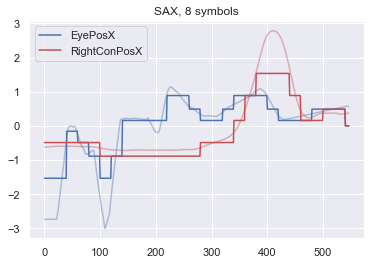

In [26]:
# dataset_1 = np.array(data[0])
# dataset_2 = dataset_1[:,3]
n1 = 0
n2 = 0
dataset_1 = np.array(data_right[n1][result_new_right[n1][n2][0]:result_new_right[n1][n2][1]])
# dataset_1 = np.array(data_right[n1])
dataset_eye_1 = dataset_1[:,0]
dataset_eye_re = np.reshape(dataset_eye_1,(1,len(dataset_eye_1)))
dataset_hand_1 = dataset_1[:,12]
dataset_hand_re = np.reshape(dataset_hand_1,(1,len(dataset_hand_1)))
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_eye = scaler.fit_transform(dataset_eye_re)
dataset_hand = scaler.fit_transform(dataset_hand_re)


Magn = 1
# PAA transform (and inverse transform) of the data
# n_paa_segments = 10 * Magn
n_paa_segments = int(len(dataset_eye[0])/10/2)
# n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv_eye = paa.inverse_transform(paa.fit_transform(dataset_eye))
paa_dataset_inv_hand = paa.inverse_transform(paa.fit_transform(dataset_hand))
# SAX transform
# n_sax_symbols = 8 * Magn
n_sax_symbols = int(n_paa_segments*0.8)
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
sax_dataset_inv_eye = sax.inverse_transform(sax.fit_transform(dataset_eye))
sax_dataset_inv_hand = sax.inverse_transform(sax.fit_transform(dataset_hand))
dist_sax = cdist(sax_dataset_inv_eye[0], sax_dataset_inv_hand[0], metric="euclidean" )


# n_sax_symbols_avg = n_sax_symbols
# n_sax_symbols_avg = 8
# n_sax_symbols_slope = 10
# sax_1d = OneD_SymbolicAggregateApproximation(
# n_segments=n_paa_segments,
# alphabet_size_avg=n_sax_symbols_avg,
# alphabet_size_slope=n_sax_symbols_slope)
# sax_1d_eye_transformed = sax_1d.fit_transform(dataset_eye)
# sax_1d_eye = sax_1d.inverse_transform(sax_1d_eye_transformed)
# sax_1d_hand_transformed = sax_1d.fit_transform(dataset_hand)
# sax_1d_hand = sax_1d.inverse_transform(sax_1d_hand_transformed)
# dist_sax_1d = cdist(sax_1d_eye[0], sax_1d_hand[0], metric="euclidean" )


plt.plot(dataset_eye[0].ravel(), "b-", alpha=0.4)
plt.plot(dataset_hand[0].ravel(), "r-", alpha=0.4)

# plt.plot(paa_dataset_inv_eye[0].ravel(), "b-",label='EyePosX')
# plt.plot(paa_dataset_inv_hand[0].ravel(), "r-",label='RightConPosX')

plt.plot(sax_dataset_inv_eye[0].ravel(), "b-",label='EyePosX')
plt.plot(sax_dataset_inv_hand[0].ravel(), "r-",label='RightConPosX')

# plt.plot(sax_1d_eye[0].ravel(), "b-",label='EyePosX')
# plt.plot(sax_1d_hand[0].ravel(), "r-",label='RightConPosX')

plt.legend()
plt.title("SAX, %d symbols" % n_sax_symbols)
# plt.title("PAA")

# del sax_1d, sax_1d_eye_transformed, sax_1d_eye, sax_1d_hand_transformed, dist_sax_1d, sax, paa
# gc.collect()

In [ ]:
n1 = 0
n2 = 0
dataset_1 = np.array(data[n1][result_new[n1][n2][0]:result_new[n1][n2][1]])
dataset_eye_1 = dataset_1[:,0:3]
# dataset_eye_re = np.reshape(dataset_eye_1,(1,len(dataset_eye_1)))
dataset_hand_1 = dataset_1[:,12:15]
# dataset_hand_re = np.reshape(dataset_hand_1,(1,len(dataset_hand_1)))
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
# dataset_eye = scaler.fit_transform(dataset_eye_re)
# dataset_hand = scaler.fit_transform(dataset_hand_re)
dataset_eye = scaler.fit_transform(dataset_eye_1.T)
dataset_hand = scaler.fit_transform(dataset_hand_1.T)


Magn = 1
# PAA transform (and inverse transform) of the data
n_paa_segments = int(len(dataset_eye[0])/20)
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv_eye = paa.inverse_transform(paa.fit_transform(dataset_eye))
paa_dataset_inv_hand = paa.inverse_transform(paa.fit_transform(dataset_hand))
# SAX transform
n_sax_symbols = 8 * Magn
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
sax_dataset_inv_eye = sax.inverse_transform(sax.fit_transform(dataset_eye))
sax_dataset_inv_hand = sax.inverse_transform(sax.fit_transform(dataset_hand))
dist_sax = cdist(sax_dataset_inv_eye[0], sax_dataset_inv_hand[0], metric="euclidean" )

n = 1
plt.plot(dataset_eye[n].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv_eye[n].ravel(), "b-",label='EyePosX')
plt.plot(dataset_hand[n].ravel(), "r-", alpha=0.4)
plt.plot(sax_dataset_inv_hand[n].ravel(), "r-",label='RightConPosX')
plt.legend()
plt.title("SAX, %d symbols" % n_sax_symbols)

# del sax_1d, sax_1d_eye_transformed, sax_1d_eye, sax_1d_hand_transformed, dist_sax_1d, sax, paa
# gc.collect()

In [ ]:
n = 0
Magn = 1
ul = 300
print("     X    Y   Z")
for i in range(1):
  n = n + len(result_new_right[i])
  for j in range(n-len(result_new_right[i]),n):
      dataset = np.array(data_right[i][result_new_right[i][j+len(result_new_right[i])-n][0]:result_new_right[i][j+len(result_new_right[i])-n][1]])
      lag_sax_x, lag_paa= find_sax_lag(dataset, 'X', Magn, ul)
      lag_sax_y, lag_paa= find_sax_lag(dataset, 'Y', Magn, ul)
      lag_sax_z, lag_paa= find_sax_lag(dataset, 'Z', Magn, ul)
      print('lag:',end=" ")
      print(lag_sax_x,end=" ")
      print(lag_sax_y,end=" ")
      print(lag_sax_z,end="\n")

In [ ]:
result_new_right[0]

In [ ]:
################## find lag ##########################
def lag_distribution(data,result_new,labels,axis='X',ul=300,Magn=1,arm='right'):
    n = 0
    lag_array = []
    lag_array1 = []
    lag_array2 = []
    lag_array3 = []
    lag_array4 = []
    lag_array5 = []
    lag_array6 = []
    lag_array7 = []
    lag_array8 = []
    lag_sax_array = []
    lag_sax_array1 = []
    lag_sax_array2 = []
    lag_sax_array3 = []
    lag_sax_array4 = []
    lag_sax_array5 = []
    lag_sax_array6 = []
    lag_sax_array7 = []
    lag_sax_array8 = []
    lag_paa_array = []
    lag_paa_array1 = []
    lag_paa_array2 = []
    lag_paa_array3 = []
    lag_paa_array4 = []
    lag_paa_array5 = []
    lag_paa_array6 = []
    lag_paa_array7 = []
    lag_paa_array8 = []

    for i in range(len(data)):
        n = n + len(result_new[i])
        print('n:')
        print(n)
        for j in range(n-len(result_new[i]),n):
            lag = []
            lag_sax = []
            dataset = []
            print('j:')
            print(j)
            if labels[j] == 0:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array1.append(lag)    
                lag_sax, lag_paa= find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array1.append(lag_sax)
                lag_paa_array1.append(lag_paa)
                print(0)
            elif labels[j] == 1:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array2.append(lag)       
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array2.append(lag_sax)
                lag_paa_array2.append(lag_paa)
                print(1)
            elif labels[j] == 2:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array3.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array3.append(lag_sax)
                lag_paa_array3.append(lag_paa)
                print(2)
            elif labels[j] == 3:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array4.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array4.append(lag_sax)
                lag_paa_array4.append(lag_paa)
                print(3)
            elif labels[j] == 4:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array5.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array5.append(lag_sax)
                lag_paa_array5.append(lag_paa)
                print(4)
            elif labels[j] == 5:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array6.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array6.append(lag_sax)
                lag_paa_array6.append(lag_paa)
                print(5)
            elif labels[j] == 6:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array7.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array7.append(lag_sax)
                lag_paa_array7.append(lag_paa)
                print(6)
            elif labels[j] == 7:
                dataset = np.array(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
                lag = find_lag(dataset, axis, ul, arm)
                lag_array8.append(lag)
                lag_sax, lag_paa = find_sax_lag(dataset, axis, Magn, ul, arm)
                lag_sax_array8.append(lag_sax)
                lag_paa_array8.append(lag_paa)
                print(7)
    lag_array = [lag_array1,lag_array2,lag_array3,lag_array4,lag_array5,lag_array6,lag_array7,lag_array8]
    lag_sax_array = [lag_sax_array1,lag_sax_array2,lag_sax_array3,lag_sax_array4,lag_sax_array5,lag_sax_array6,lag_sax_array7,lag_sax_array8]
    lag_paa_array = [lag_paa_array1,lag_paa_array2,lag_paa_array3,lag_paa_array4,lag_paa_array5,lag_paa_array6,lag_paa_array7,lag_paa_array8]
    lag = [lag_array1,lag_array2,lag_array3,lag_array4,lag_array5,lag_array6,lag_array7,lag_array8,lag_sax_array1,lag_sax_array2,lag_sax_array3,lag_sax_array4,lag_sax_array5,lag_sax_array6,lag_sax_array7,lag_sax_array8,lag_paa_array1,lag_paa_array2,lag_paa_array3,lag_paa_array4,lag_paa_array5,lag_paa_array6,lag_paa_array7,lag_paa_array8]
    return lag_array, lag_sax_array, lag_paa_array, lag

In [ ]:
lag_array_right_x, lag_sax_array_right_x, lag_paa_array_right_x, lag_right_x = lag_distribution(data_right,result_new_right,labels_right,axis='X',ul=300,Magn=1,arm='right')
lag_array_right_y, lag_sax_array_right_y, lag_paa_array_right_y, lag_right_y = lag_distribution(data_right,result_new_right,labels_right,axis='Y',ul=300,Magn=1,arm='right')
lag_array_right_z, lag_sax_array_right_z, lag_paa_array_right_z, lag_right_z = lag_distribution(data_right,result_new_right,labels_right,axis='Z',ul=300,Magn=1,arm='right')

lag_array_left_x, lag_sax_array_left_x, lag_paa_array_left_x, lag_left_x = lag_distribution(data_left,result_new_left,labels_left,axis='X',ul=300,Magn=1,arm='left')
lag_array_left_y, lag_sax_array_left_y, lag_paa_array_left_y, lag_left_y = lag_distribution(data_left,result_new_left,labels_left,axis='Y',ul=300,Magn=1,arm='left')
lag_array_left_z, lag_sax_array_left_z, lag_paa_array_left_z, lag_left_z = lag_distribution(data_left,result_new_left,labels_left,axis='Z',ul=300,Magn=1,arm='left')

pattern_lag_right = []
pattern_lag_left = []
pattern_lag_right.append(lag_sax_array_right_x)
pattern_lag_right.append(lag_sax_array_right_y)
pattern_lag_right.append(lag_sax_array_right_z)
pattern_lag_left.append(lag_sax_array_left_x)
pattern_lag_left.append(lag_sax_array_left_y)
pattern_lag_left.append(lag_sax_array_left_z)

plt.figure()
plt.boxplot(lag_sax_array_right_x)
plt.title('lag_right_x')
plt.figure()
plt.boxplot(lag_sax_array_right_y)
plt.title('lag_right_y')
plt.figure()
plt.boxplot(lag_sax_array_right_z)
plt.title('lag_right_z')
plt.figure()
plt.boxplot(lag_sax_array_left_x)
plt.title('lag_left_x')
plt.figure()
plt.boxplot(lag_sax_array_left_y)
plt.title('lag_left_y')
plt.figure()
plt.boxplot(lag_sax_array_left_z)
plt.title('lag_left_z')




In [ ]:
    pattern_lag_right = np.load(path + 'pattern_lag_right.npy',allow_pickle=True)
    pattern_lag_left = np.load(path + 'pattern_lag_left.npy',allow_pickle=True)

In [ ]:
pattern_lag_right[0]
plt.figure()
plt.boxplot(pattern_lag_right[0])
plt.title('lag_right_x')
plt.figure()
plt.boxplot(pattern_lag_right[1])
plt.title('lag_right_y')
plt.figure()
plt.boxplot(pattern_lag_right[2])
plt.title('lag_right_z')
plt.figure()
plt.boxplot(pattern_lag_left[0])
plt.title('lag_left_x')
plt.figure()
plt.boxplot(pattern_lag_left[1])
plt.title('lag_left_y')
plt.figure()
plt.boxplot(pattern_lag_left[2])
plt.title('lag_left_z')

In [ ]:
shift_right = np.linspace(1,24,24).reshape(3,8)
shift_left = np.linspace(1,24,24).reshape(3,8)

In [ ]:
len(pattern_lag_left[0])

In [ ]:
for i in range(len(pattern_lag_left)):
    for j in range(len(pattern_lag_left[0])):
        if np.average(pattern_lag_right[i][j]) < 40:
            shift_right[i][j] = 40
        else:
            shift_right[i][j] = np.average(pattern_lag_right[i][j])
        if np.average(pattern_lag_left[i][j]) < 40:
            shift_left[i][j] = 40
        else:
            shift_left[i][j] = np.average(pattern_lag_left[i][j])
shift_right = np.array(shift_right).astype(int)
shift_left = np.array(shift_left).astype(int)

In [64]:
print(shift_right)
print(shift_left)

[[ 45  40 244 232 237  42  43 251]
 [ 41 227 250  40  55 259  40 248]
 [252  60 258  40 236 256  49  60]]
[[245  40  44  54 248 232  55  58]
 [257  50  40 253  46  46 259  40]
 [194 157  40 248 262  40  44 278]]


In [ ]:
shift_right = [[40,40,260,240,240,40,40,280],[40,230,260,40,40,280,40,260],[280,40,280,40,240,280,40,50]]
shift_left = [[260,40,40,50,260,240,50,50],[280,40,40,280,40,40,280,40],[210,160,40,260,280,40,40,280]]

In [87]:
total_right_1 = 0
total_right_2 = 0
total_right_3 = 0
total_left_1 = 0
total_left_2 = 0
total_left_3 = 0
right_count_1 = 0
right_count_2 = 0
right_count_3 = 0
left_count_1 = 0
left_count_2 = 0
left_count_3 = 0
for i in range(len(lag_sax_array_right[0])):
    if labels_right[i] == 0:
      total_right_1 = total_right_1 + lag_sax_array_right[:,i]
      right_count_1 = right_count_1 + 1
    elif labels_right[i] == 1:
      total_right_2 = total_right_2 + lag_sax_array_right[:,i]
      right_count_2 = right_count_2 + 1
    elif labels_right[i] == 2:
      total_right_3 = total_right_3 + lag_sax_array_right[:,i]
      right_count_3 = right_count_3 + 1

for i in range(len(lag_sax_array_left[0])):
    if labels_left[i] == 0:
      total_left_1 = total_left_1 + lag_sax_array_left[:,i]
      left_count_1 = left_count_1 + 1
    elif labels_left[i] == 1:
      total_left_2 = total_left_2 + lag_sax_array_left[:,i]
      left_count_2 = left_count_2 + 1
    elif labels_left[i] == 2:
      total_left_3 = total_left_3 + lag_sax_array_left[:,i]
      left_count_3 = left_count_3 + 1

average_right_1 = total_right_1/right_count_1
average_right_2 = total_right_2/right_count_2
average_right_3 = total_right_3/right_count_3
average_left_1 = total_left_1/left_count_1
average_left_2 = total_left_2/left_count_2
average_left_3 = total_left_3/left_count_3
shift_right = np.array([average_right_1,average_right_2,average_right_3]).T.astype(int)
shift_left = np.array([average_left_1,average_left_2,average_left_3]).T.astype(int)

In [85]:
average_right_1

array([62.875, 58.6  , 62.15 ])

In [89]:
np.save(path + 'shift_right.npy',shift_right)
np.save(path + 'shift_left.npy',shift_left)

In [88]:
shift_right

array([[ 62,  71,  55],
       [ 58,  59, 264],
       [ 62, 269, 244]])

In [84]:
shift_right

array([[ 62.875     ,  58.6       ,  62.15      ],
       [ 71.57894737,  59.47368421, 269.47368421],
       [ 55.        , 264.5       , 244.5       ]])

In [ ]:
shift_left

In [ ]:
shift_right = np.load(path + 'shift_right.npy',allow_pickle=True)

In [ ]:
shift_right[0,3]

In [ ]:
path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/training_data/'

In [ ]:
for file_path in os.listdir(path):
    print(os.path.basename(file_path)[6:7])

In [ ]:
np.save(path2 + 'lag_array.npy',lag_array)
np.save(path2 + 'lag_sax_array.npy',lag_sax_array)

In [ ]:
def lag_to_csv(lag_sax_array,path,axis,hand):
    # max_len=max(len(lag_array[0]),len(lag_array[1]),len(lag_array[2]),len(lag_array[3]),len(lag_sax_array[0]),len(lag_sax_array[1]),len(lag_sax_array[2]),len(lag_sax_array[3]),len(lag_paa_array[0]),len(lag_paa_array[1]),len(lag_paa_array[2]),len(lag_paa_array[3]))
    max_len=max(len(lag_sax_array[0]),len(lag_sax_array[1]),len(lag_sax_array[2]),len(lag_sax_array[3]),len(lag_sax_array[4]),len(lag_sax_array[5]),len(lag_sax_array[6]),len(lag_sax_array[7]))
    # add_ori_1=max_len-len(lag_array[0])
    # add_ori_2=max_len-len(lag_array[1])
    # add_ori_3=max_len-len(lag_array[2])
    # add_ori_4=max_len-len(lag_array[3])
    add_sax_1=max_len-len(lag_sax_array[0])
    add_sax_2=max_len-len(lag_sax_array[1])
    add_sax_3=max_len-len(lag_sax_array[2])
    add_sax_4=max_len-len(lag_sax_array[3])
    add_sax_5=max_len-len(lag_sax_array[4])
    add_sax_6=max_len-len(lag_sax_array[5])
    add_sax_7=max_len-len(lag_sax_array[6])
    add_sax_8=max_len-len(lag_sax_array[7])
    # lag_array[0].extend(add_ori_1*[''])
    # lag_array[1].extend(add_ori_2*[''])
    # lag_array[2].extend(add_ori_3*[''])
    # lag_array[3].extend(add_ori_4*[''])
    lag_sax_array[0].extend(add_sax_1*[''])
    lag_sax_array[1].extend(add_sax_2*[''])
    lag_sax_array[2].extend(add_sax_3*[''])
    lag_sax_array[3].extend(add_sax_4*[''])
    lag_sax_array[4].extend(add_sax_5*[''])
    lag_sax_array[5].extend(add_sax_6*[''])
    lag_sax_array[6].extend(add_sax_7*[''])
    lag_sax_array[7].extend(add_sax_8*[''])
    # lag_paa_array[0].extend(add_sax_1*[''])
    # lag_paa_array[1].extend(add_sax_2*[''])
    # lag_paa_array[2].extend(add_sax_3*[''])
    # lag_paa_array[3].extend(add_sax_4*[''])

    with open(path + 'lag_' + hand + '_' + axis + '.csv', 'w', newline='') as f:
        writer=csv.writer(f)
        # header='pattern_1_ori','pattern_2_ori','pattern_3_ori','pattern_4_ori','pattern_1_sax','pattern_2_sax','pattern_3_sax','pattern_4_sax','pattern_1_paa','pattern_2_paa','pattern_3_paa','pattern_4_paa'
        header='pattern_1_sax_' + axis,'pattern_2_sax_' + axis,'pattern_3_sax_' + axis,'pattern_4_sax_' + axis,'pattern_5_sax_' + axis,'pattern_6_sax_' + axis,'pattern_7_sax_' + axis,'pattern_8_sax_' + axis
        writer.writerow(header)
        # writer.writerows(zip(lag_array[0],lag_array[1],lag_array[2],lag_array[3],lag_sax_array[0],lag_sax_array[1],lag_sax_array[2],lag_sax_array[3],lag_paa_array[0],lag_paa_array[1],lag_paa_array[2],lag_paa_array[3]))
        writer.writerows(zip(lag_sax_array[0],lag_sax_array[1],lag_sax_array[2],lag_sax_array[3],lag_sax_array[4],lag_sax_array[5],lag_sax_array[6],lag_sax_array[7]))

In [ ]:
path = path5
lag_to_csv(lag_sax_array_right_x,path,'x','right')
lag_to_csv(lag_sax_array_right_y,path,'y','right')
lag_to_csv(lag_sax_array_right_z,path,'z','right')
csv1 = pd.read_csv(path + 'lag_right_x.csv')
csv2 = pd.read_csv(path + 'lag_right_y.csv')
csv3 = pd.read_csv(path + 'lag_right_z.csv')
out_csv=pd.concat([csv1,csv2,csv3],axis=1)
out_csv.to_csv(path + 'lag_right.csv',index=False)
lag_to_csv(lag_sax_array_left_x,path,'x','left')
lag_to_csv(lag_sax_array_left_y,path,'y','left')
lag_to_csv(lag_sax_array_left_z,path,'z','left')
csv1 = pd.read_csv(path + 'lag_left_x.csv')
csv2 = pd.read_csv(path + 'lag_left_y.csv')
csv3 = pd.read_csv(path + 'lag_left_z.csv')
out_csv=pd.concat([csv1,csv2,csv3],axis=1)
out_csv.to_csv(path + 'lag_left.csv',index=False)

path = path5
np.save(path + 'lag_sax_array_right_x.npy',lag_sax_array_right_x)
np.save(path + 'lag_sax_array_right_y.npy',lag_sax_array_right_y)
np.save(path + 'lag_sax_array_right_z.npy',lag_sax_array_right_z)
np.save(path + 'lag_sax_array_left_x.npy',lag_sax_array_left_x)
np.save(path + 'lag_sax_array_left_y.npy',lag_sax_array_left_y)
np.save(path + 'lag_sax_array_left_z.npy',lag_sax_array_left_z)


In [ ]:
import tsaug
from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

In [ ]:
tsaug.

In [ ]:
X = np.array(data[0]['EyePosX'])
Y = np.array(data[0]['EyePosY'])
Z = np.array(data[0]['EyePosZ'])


In [ ]:
X = np.load(path5 + 'X.npy')
Y = np.load(path5 + 'Y.npy')

In [ ]:
my_augmenter = (
    Crop(size=300)
)

In [ ]:
Y

In [ ]:
plot(X)

In [ ]:
plot(Y)

In [ ]:
plot(X,Y)

In [ ]:
X_a,Y_a = my_augmenter.augment(X,Y)
plot(X_a,Y_a)

In [ ]:
# X_a = tsaug.Drift(max_drift=0.7, n_drift_points=50).augment(X)
# X_a = tsaug.Pool(size=100).augment(X)
# X_a = tsaug.Quantize(n_levels=20).augment(X)
X_a = tsaug.TimeWarp(n_speed_change=5, max_speed_ratio=3).augment(X)

In [ ]:
# plt.figure(figsize=(6,8))
# plt.subplot(2,1,1)
plt.plot(X.ravel(), "b-", alpha=0.4, label='original')
plt.plot(X_a.ravel(), "r-",label='augmentation')
# plt.plot(dataset_hand[0].ravel(), "r-", alpha=0.4)
# plt.plot(sax_dataset_inv_hand[0].ravel(), "r-",label='RightConPosX')
plt.legend()
# plt.title("SAX, %d symbols" % n_sax_symbols)

In [ ]:
labels

In [ ]:
result_new

In [ ]:
################## fengexian ##########################
n = 0
n1 = 0
n2 = 0
n3 = 0
n4 = 0
pattern_1=pd.read_csv(path2 + 'label_1.csv',index_col=0)
pattern_2=pd.read_csv(path2 + 'label_2.csv',index_col=0)
pattern_3=pd.read_csv(path2 + 'label_3.csv',index_col=0)
pattern_4=pd.read_csv(path2 + 'label_4.csv',index_col=0)
plt.figure(1)
plt.plot(pattern_1['RightConPosX'])
plt.figure(2)
plt.plot(pattern_2['RightConPosX'])
plt.figure(3)
plt.plot(pattern_3['RightConPosX'])
plt.figure(4)
plt.plot(pattern_4['RightConPosX'])
for i in range(len(data)):
  n = n + len(result_new[i])
  print('n:')
  print(n)
  for j in range(n-len(result_new[i]),n):
    print('j:')
    print(j)
    if labels[j] == 0:
        # n1 = n1 + len(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
        n1 = n1 + result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0]
        plt.figure(1)
        plt.vlines(n1, 2.0, 4.0, colors = "r")

    elif labels[j] == 1:
        # n2 = n2 + len(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
        n2 = n2 + result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0]
        plt.figure(2)
        plt.vlines(n2, 2.0, 4.0, colors = "r")

    elif labels[j] == 2:
        # n3 = n3 + len(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
        n3 = n3 + result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0]
        plt.figure(3)
        plt.vlines(n3, 2.0, 4.0, colors = "r")

    elif labels[j] == 3:
        # n4 = n4 + len(data[i][result_new[i][j+len(result_new[i])-n][0]:result_new[i][j+len(result_new[i])-n][1]])
        n4 = n4 + result_new[i][j+len(result_new[i])-n][1] - result_new[i][j+len(result_new[i])-n][0]
        plt.figure(4)
        plt.vlines(n4, 2.0, 4.0, colors = "r")


In [ ]:
print(n1)

In [ ]:
print(len(pattern_1['RightConPosX']))

In [ ]:
################## fengexian ##########################
n = 0
n1 = 0
n2 = 0
n3 = 0
n4 = 0
pattern_1=pd.read_csv(path5 + 'label_1.csv',index_col=0)
pattern_2=pd.read_csv(path5 + 'label_2.csv',index_col=0)
pattern_3=pd.read_csv(path5 + 'label_3.csv',index_col=0)
pattern_4=pd.read_csv(path5 + 'label_4.csv',index_col=0)
plt.figure(1)
plt.plot(pattern_1['RightConPosX'])
plt.figure(2)
plt.plot(pattern_2['RightConPosX'])
plt.figure(3)
plt.plot(pattern_3['RightConPosX'])
plt.figure(4)
plt.plot(pattern_4['RightConPosX'])
for i in range(len(data)):
  n = n + len(result_new[i])
  print('n:')
  print(n)
  for j in range(n-len(result_new[i]),n-1):
    print('j:')
    print(j)
    if labels[j] == 0:
        n1 = n1 + len(data[i][result[i][j+len(result[i])-n]:result[i][j+len(result[i])-n+1]])
        plt.figure(1)
        plt.vlines(n1, 2.0, 4.0, colors = "r")

    elif labels[j] == 1:
        n2 = n2 + len(data[i][result[i][j+len(result[i])-n]:result[i][j+len(result[i])-n+1]])
        plt.figure(2)
        plt.vlines(n2, 2.0, 4.0, colors = "r")

    elif labels[j] == 2:
        n3 = n3 + len(data[i][result[i][j+len(result[i])-n]:result[i][j+len(result[i])-n+1]])
        plt.figure(3)
        plt.vlines(n3, 2.0, 4.0, colors = "r")

    elif labels[j] == 3:
        n4 = n4 + len(data[i][result[i][j+len(result[i])-n]:result[i][j+len(result[i])-n+1]])
        plt.figure(4)
        plt.vlines(n4, 2.0, 4.0, colors = "r")


In [ ]:
p = 'right_'
data_right[0].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig")
for i in range(1,len(data_right)):
    data_right[i].to_csv(path7 + p + 'all.csv',encoding="utf_8_sig", header=False, mode='a+')
df = pd.read_csv(path4 + 'all.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.to_csv(SaveFile_Path + SaveFile_Name,encoding="utf_8_sig")

In [ ]:
Folder_Path = path1          #要拼接的文件夹及其完整路径，注意不要包含中文
SaveFile_Path =  path4       #拼接后要保存的文件路径
SaveFile_Name = 'all.csv'              #合并后要保存的文件名

#修改当前工作目录
# os.chdir(Folder_Path)
#将该文件夹下的所有文件名存入一个列表
file_list = os.listdir(Folder_Path)
 
#读取第一个CSV文件并包含表头
df_raw = pd.read_csv(Folder_Path + file_list[0])   #编码默认UTF-8，若乱码自行更改
df = df_raw[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']]
df = moving(df)

df['EyePosX'][df['EyePosX']<np.min(df['RightConPosX'])] = np.nan
df['EyePosX'][df['EyePosX']>np.max(df['RightConPosX'])] = np.nan
df['EyePosY'][df['EyePosY']<np.min(df['RightConPosY'])] = np.nan
df['EyePosY'][df['EyePosY']>np.max(df['RightConPosY'])] = np.nan
df['EyePosZ'][df['EyePosZ']<np.min(df['RightConPosZ'])] = np.nan
df['EyePosZ'][df['EyePosZ']>np.max(df['RightConPosZ'])] = np.nan
df = df.interpolate(method='linear',axis=0,limit_direction ='both')
df = moving(df)
df['label'] = 0
#将读取的第一个CSV文件写入合并后的文件保存
df.to_csv(SaveFile_Path + SaveFile_Name,encoding="utf_8_sig")
 
#循环遍历列表中各个CSV文件名，并追加到合并后的文件
for i in range(1,len(file_list)):
    df_raw = pd.read_csv(Folder_Path + file_list[i])
    df = df_raw[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']]
    df['EyePosX'][df['EyePosX']<np.min(df['RightConPosX'])] = np.nan
    df['EyePosX'][df['EyePosX']>np.max(df['RightConPosX'])] = np.nan
    df['EyePosY'][df['EyePosY']<np.min(df['RightConPosY'])] = np.nan
    df['EyePosY'][df['EyePosY']>np.max(df['RightConPosY'])] = np.nan
    df['EyePosZ'][df['EyePosZ']<np.min(df['RightConPosZ'])] = np.nan
    df['EyePosZ'][df['EyePosZ']>np.max(df['RightConPosZ'])] = np.nan
    df = df.interpolate(method='linear',axis=0,limit_direction ='both')
    df = moving(df)
    df['label'] = i
    df.to_csv(SaveFile_Path + SaveFile_Name,encoding="utf_8_sig", header=False, mode='a+')
df = pd.read_csv(path4 + 'all.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.to_csv(SaveFile_Path + SaveFile_Name,encoding="utf_8_sig")

In [ ]:
#################### hierarchical clustering ############
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.shapelets import LearningShapelets
from tslearn.svm import TimeSeriesSVR
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.clustering import KernelKMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.barycenters import softdtw_barycenter
from tslearn.utils import ts_zeros
from sklearn.model_selection import KFold, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.generators import random_walk_blobs
from tslearn.clustering import KShape
from tslearn.metrics import cdist_dtw, cdist_soft_dtw, cdist_soft_dtw_normalized
from sklearn.cluster import SpectralClustering, AgglomerativeClustering




In [ ]:
X = to_time_series_dataset([[1, 2, 3, 4], [1, 2, 3], [2, 5, 6, 7, 8, 9],[3,4,5,6,7]])
y = [0, 0, 1, 0]
X_test = [[10, 1, 6, 7, 8, 9]]

In [ ]:
X2[0:20].shape

In [ ]:
alignment = dtw(X1_norm[0], X1_norm[1], keep_internals=True, 
step_pattern=rabinerJuangStepPattern(6, "c"))
alignment.plot(type="threeway")
print(alignment.distance)
print(alignment.distance/len(X1[1]))
print(alignment.normalizedDistance)

In [ ]:
alignment.distance/len(X1[1])

In [ ]:
alignment.normalizedDistance

In [ ]:
cdist_dtw(X1_norm[0:5])

In [ ]:
cdist_soft_dtw(X1_norm[0:5],gamma=0.01)

In [ ]:
cdist_soft_dtw_normalized(X1_norm[0:5],gamma=0.01)

In [ ]:
dist_dtw = cdist_dtw(X2)
dist_softdtw = cdist_soft_dtw(X2,gamma=0.01)
dist_softdtwnorm = cdist_soft_dtw_normalized(X2,gamma=0.001)


In [ ]:
np.save(path2 + 'dist_dtw.npy',dist_dtw)
np.save(path2 + 'dist_softdtw.npy',dist_softdtw)
np.save(path2 + 'dist_softdtwnorm.npy',dist_softdtwnorm)

In [ ]:
dist_softdtwnorm[0:5]

In [ ]:
clustering = SpectralClustering(n_clusters=4,random_state=0)
clustering.fit_predict(dist_dtw)
# clustering.fit_predict(dist_softdtw)
# clustering.fit_predict(dist_softdtwnorm)

In [ ]:
AC = AgglomerativeClustering(n_clusters=4, affinity='precomputed',linkage='complete')
AC.fit_predict(dist_dtw)
# AC.fit_predict(dist_softdtw)
# AC.fit_predict(dist_softdtwnorm)

In [ ]:
n1 = 0
n2 = 30
# print(clustering.fit_predict(cdist_dtw(X1_norm[n1:n2])))
# print(clustering.fit_predict(cdist_soft_dtw(X1_norm[n1:n2],gamma=0.01)))
# print(clustering.fit_predict(cdist_soft_dtw_normalized(X1_norm[n1:n2],gamma=0.001)))
print(AC.fit_predict(cdist_dtw(X1_norm[n1:n2])))
print(AC.fit_predict(cdist_soft_dtw(X1_norm[n1:n2],gamma=0.01)))
print(AC.fit_predict(cdist_soft_dtw_normalized(X1_norm[n1:n2],gamma=0.001)))
km = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=0)
print(km.fit_predict(X2[n1:n2]))

In [ ]:
print(AC.fit_predict(cdist_dtw(X2[0:10])))
print(AC.fit_predict(cdist_soft_dtw(X2[0:10],gamma=0.01)))
print(AC.fit_predict(cdist_soft_dtw_normalized(X2[0:10],gamma=0.001)))
km = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=0)
print(km.fit_predict(X2[0:10]))

In [ ]:
######################################################

In [ ]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=2)
knn.fit(X, y).predict(X_test)

In [ ]:
clf = TimeSeriesSVC(C=1.0, kernel="gak")
clf.fit(X, y).predict([[9,2,8,9,8]])

In [ ]:
gak_km = KernelKMeans(n_clusters=2, kernel="gak")
labels_gak = gak_km.fit_predict(X)
labels_gak

In [ ]:
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
labels = km.fit_predict(X)
silhouette_score(X, labels, metric="dtw")

In [ ]:
bar = dtw_barycenter_averaging(X, barycenter_size=3)


In [ ]:
initial_barycenter = ts_zeros(sz=5)
bar = softdtw_barycenter(X, init=initial_barycenter)

In [ ]:
bar

In [ ]:
resampled_X = TimeSeriesResampler(sz=X.shape[1]).fit_transform(X)


In [ ]:
resampled_X

In [32]:
lag_sax_array_right
lag_sax_array_left

array([[100, 100,  40,  40,  60, 220, 180,  40,  40,  60,  40, 100,  40,
         80,  80, 160,  60,  40, 120,  60,  40,  40,  74,  40,  60, 140,
        100,  40,  80, 100, 100,  40,  80,  60, 100,  80],
       [160,  40,  60, 220, 120,   0, 100,  20, 100,  40,  40,   0,  40,
         60, 260, 299,  60,  40,  20,  80,  40,   0,  60,  40,  80,  40,
         20,  20,   0, 120,  60, 120,  80,  60,  60,  40],
       [ 40,  20, 260, 299, 100,   0, 280,  40, 160, 200, 120,  60,   0,
          0, 299, 299, 299,   0, 200, 100,  80, 180,   0,  80,   0,   0,
        299,  80,   0, 245,   0,   0, 100,   0, 260, 120]])

D:\Tianyu\software\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


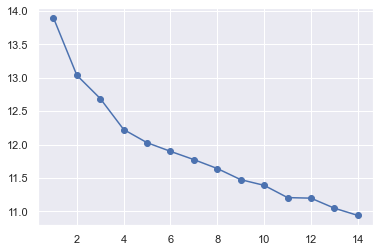

In [28]:
## 手肘法 ##
wcss_right=[]
for i in range(1,15):
    kmeans=KMeans(i)
    kmeans.fit(lag_sax_array_right.T)
    wcss_right.append(kmeans.inertia_)
X = range(1,15)
plt.plot(X,np.log(wcss_right),'o-')

D:\Tianyu\software\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


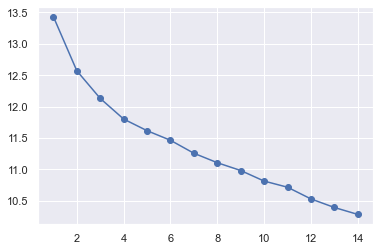

In [29]:
wcss_left=[]
for i in range(1,15):
    kmeans=KMeans(i)
    kmeans.fit(lag_sax_array_left.T)
    wcss_left.append(kmeans.inertia_)
X = range(1,15)
plt.plot(X,np.log(wcss_left),'o-')

In [30]:
## gap statistic ## 
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import numpy as np
EuclDist = scipy.spatial.distance.euclidean
def gapStat(data, resf=None, nrefs=50, ks=range(1,20)):
    '''
    Gap statistics
    '''
    # MC
    shape = data.shape
    if resf == None:
        x_max = data.max(axis=0)
        x_min = data.min(axis=0)
        dists = np.matrix(np.diag(x_max-x_min))
        rands = np.random.random_sample(size=(shape[0], shape[1], nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+x_min
    else:
        rands = refs
    s1 = np.zeros((len(ks),))
    s2 = np.zeros((len(ks),))
    gaps = np.zeros((len(ks),))
    gapDiff = np.zeros(len(ks)-1,)
    sdk = np.zeros(len(ks),)
    for (i,k) in enumerate(ks):
        (cluster_mean, cluster_res) = scipy.cluster.vq.kmeans2(data, k)
        Wk = sum([EuclDist(data[m,:], cluster_mean[cluster_res[m],:]) for m in range(shape[0])])
        WkRef = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            WkRef[j] = sum([EuclDist(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        s1[i] = scipy.log(Wk)
        s2[i] = scipy.log(scipy.mean(WkRef))
        gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
        sdk[i] = np.sqrt((1.0+nrefs)/nrefs)*np.std(scipy.log(WkRef))

        if i > 0:
            gapDiff[i-1] = gaps[i-1] - gaps[i] + sdk[i]
    return gaps, gapDiff, s2, s1


<ipython-input-30-0f0756815383>:34: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  s1[i] = scipy.log(Wk)
<ipython-input-30-0f0756815383>:35: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  s2[i] = scipy.log(scipy.mean(WkRef))
<ipython-input-30-0f0756815383>:35: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  s2[i] = scipy.log(scipy.mean(WkRef))
<ipython-input-30-0f0756815383>:36: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
<ipython-input-30-0f0756815383>:36: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
<ipython-input-30-0f0756815383>:37: DeprecationWarning: sc

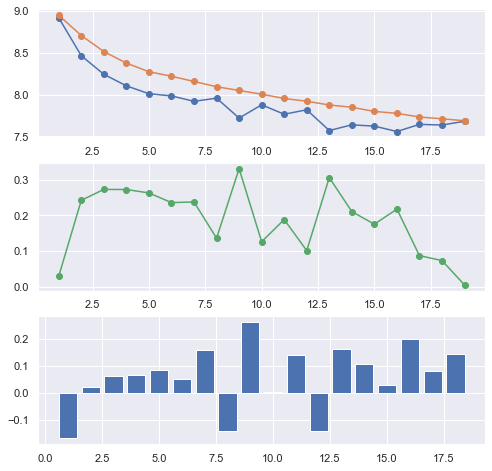

In [31]:
gaps,gapsDiff, s2, s1 = gapStat(lag_sax_array_right.T.astype(float))
X = range(1,20)
f, (a1,a2,a3) = plt.subplots(3,1,figsize=(8,8))
a1.plot(X,s1,'o-')
a1.plot(X,s2,'o-')
a2.plot(X,gaps, 'g-o')
a3.bar(np.arange(1,19),gapsDiff)
f.show()

<ipython-input-30-0f0756815383>:34: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  s1[i] = scipy.log(Wk)
<ipython-input-30-0f0756815383>:35: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  s2[i] = scipy.log(scipy.mean(WkRef))
<ipython-input-30-0f0756815383>:35: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  s2[i] = scipy.log(scipy.mean(WkRef))
<ipython-input-30-0f0756815383>:36: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
<ipython-input-30-0f0756815383>:36: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
<ipython-input-30-0f0756815383>:37: DeprecationWarning: sc

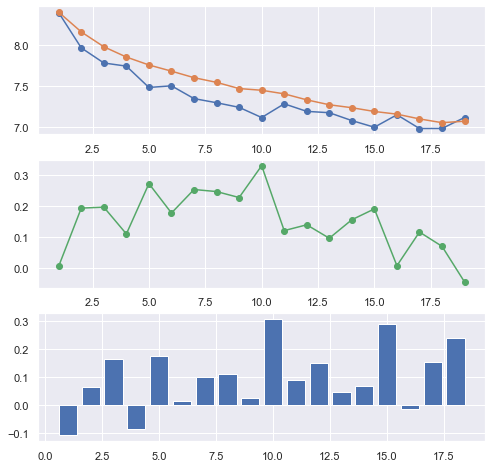

In [33]:
gaps,gapsDiff, s2, s1 = gapStat(lag_sax_array_left.T.astype(float))
X = range(1,20)
f, (a1,a2,a3) = plt.subplots(3,1,figsize=(8,8))
a1.plot(X,s1,'o-')
a1.plot(X,s2,'o-')
a2.plot(X,gaps, 'g-o')
a3.bar(np.arange(1,19),gapsDiff)
f.show()

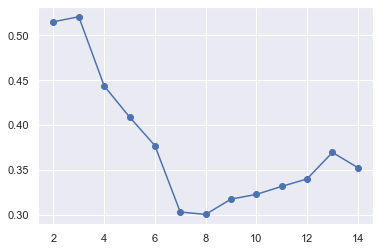

In [34]:
## Silhouette Coefficient ##
Scores = []
for i in range(2,15):
    estimator = KMeans(i)
    estimator.fit(lag_sax_array_right.T)
    Scores.append(silhouette_score(lag_sax_array_right.T,estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.plot(X,Scores,'o-')

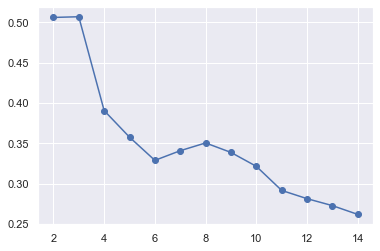

In [35]:
Scores = []
for i in range(2,15):
    estimator = KMeans(i)
    estimator.fit(lag_sax_array_left.T)
    Scores.append(silhouette_score(lag_sax_array_left.T,estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.plot(X,Scores,'o-')

In [ ]:
test_re = data[0].reindex(columns=['LeftConPosX+', 'LeftConPosY','LeftConPosZ'])

In [ ]:
test_re

['101_HMD.csv']


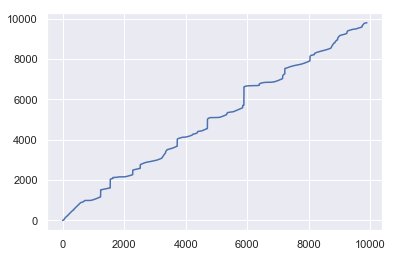

In [12]:
def find_dominant_arm(data):
    dominant_arm = []
    # data = np.array(data)
    # left_std1 = data[:,9].std()
    # left_std2 = data[:,10].std()
    # left_std3 = data[:,11].std()
    # left_std = np.average([left_std1, left_std2, left_std3])
    # right_std1 = data[:,12].std()
    # right_std2 = data[:,13].std()
    # right_std3 = data[:,14].std()
    # right_std = np.average([right_std1, right_std2, right_std3])
    
    left_std1 = data['LeftConPosX'].std()
    left_std2 = data['LeftConPosY'].std()
    left_std3 = data['LeftConPosZ'].std()
    left_std = np.average([left_std1, left_std2, left_std3])
    right_std1 = data['RightConPosX'].std()
    right_std2 = data['RightConPosY'].std()
    right_std3 = data['RightConPosZ'].std()
    right_std = np.average([right_std1, right_std2, right_std3])
    
    if right_std >= left_std:
        # dominant_arm.append(['right',right_std,left_std])
        dominant_arm.append('right')
    else:
        # dominant_arm.append(['left',right_std,left_std])
        dominant_arm.append('left')

    del left_std1, left_std2, left_std3, left_std, right_std1, right_std2, right_std3, right_std
    gc.collect()
    return dominant_arm

def moving(data, shi=100, method='wa', print_ans=False):
    df = data.copy()
    # name = df.at[30, 'Label']
    # df.drop(['Label'], axis=1, inplace=True)
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        if method == 'ewa':
            df_new[n] = df.loc[:, n].ewm(span=shi).mean()
        elif method == 'wa':
            df_new[n] = df.loc[:, n].rolling(window=shi, min_periods=1).mean()
    return df_new

def interpolate_data(data, arm):
    if arm == 'right':
        data['EyePosX'][data['EyePosX']<np.min(data['RightConPosX'])] = np.nan
        data['EyePosX'][data['EyePosX']>np.max(data['RightConPosX'])] = np.nan
        data['EyePosY'][data['EyePosY']<np.min(data['RightConPosY'])] = np.nan
        data['EyePosY'][data['EyePosY']>np.max(data['RightConPosY'])] = np.nan
        data['EyePosZ'][data['EyePosZ']<np.min(data['RightConPosZ'])] = np.nan
        data['EyePosZ'][data['EyePosZ']>np.max(data['RightConPosZ'])] = np.nan
    if arm == 'left':
        data['EyePosX'][data['EyePosX']<np.min(data['LeftConPosX'])] = np.nan
        data['EyePosX'][data['EyePosX']>np.max(data['LeftConPosX'])] = np.nan
        data['EyePosY'][data['EyePosY']<np.min(data['LeftConPosY'])] = np.nan
        data['EyePosY'][data['EyePosY']>np.max(data['LeftConPosY'])] = np.nan
        data['EyePosZ'][data['EyePosZ']<np.min(data['LeftConPosZ'])] = np.nan
        data['EyePosZ'][data['EyePosZ']>np.max(data['LeftConPosZ'])] = np.nan

    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data = moving(data)
    return data

def preprocess_data(path = 'D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/predict_data/'):
    data=[]
    print(os.listdir(path))
    for file_path in os.listdir(path):
        t=pd.read_csv(path+file_path,index_col=0)
        arm = ''.join(find_dominant_arm(t))
        t = interpolate_data(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']],arm)
        t.index = range(len(t))
        t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        t['Label'] = os.path.basename(file_path)[:-4]  
        # t['Arm'] = arm
        # data.append(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ']])
        data.append(t[['EyePosX','EyePosY','EyePosZ','GazePosX','GazePosY','GazePosZ','CameraPosX','CameraPosY','CameraPosZ','LeftConPosX','LeftConPosY','LeftConPosZ','RightConPosX','RightConPosY','RightConPosZ','Label']])
    return data

data = preprocess_data('D:/Tianyu/code/python/paper2/yubo/method_1109/ICIC-LAB/predict_data/')
# data=data_right
# alignment = dtw(data[0][['EyePosX','EyePosY','EyePosZ']], data[0][['LeftConPosX','LeftConPosY','LeftConPosZ']], keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))
alignment = dtw(data[0][['EyePosX','EyePosY','EyePosZ']], data[0][['RightConPosX','RightConPosY','RightConPosZ']], keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))
x = alignment.index1s
y = alignment.index2s
y_new= []
for i in range(len(y)-1):
    if x[i+1]!=x[i]:
        y_new.append(y[i+1])

plt.plot(y_new)

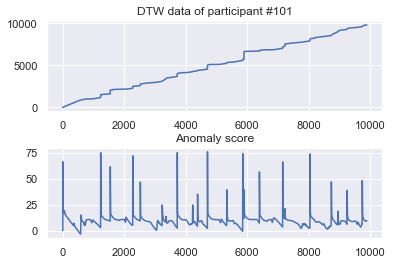

In [14]:
import changefinder
#CHANGEFINDER PACKAGE
f, (ax1, ax2) = plt.subplots(2, 1)
f.subplots_adjust(hspace=0.4)
ax1.plot(y_new)
ax1.set_title("DTW data of participant #101")
#Initiate changefinder function
cf = changefinder.ChangeFinder(r=0.02, order=1, smooth=7)
scores = [cf.update(p) for p in y_new]
ax2.plot(scores)
ax2.set_title("Anomaly score")
plt.show() 

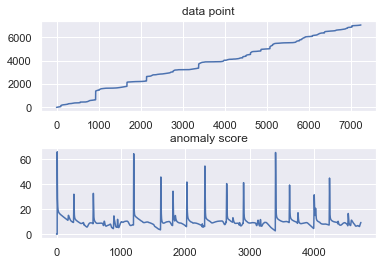

In [11]:
import changefinder
#CHANGEFINDER PACKAGE
f, (ax1, ax2) = plt.subplots(2, 1)
f.subplots_adjust(hspace=0.4)
ax1.plot(y_new_right[0])
ax1.set_title("data point")
#Initiate changefinder function
cf = changefinder.ChangeFinder(r=0.02, order=1, smooth=7)
scores = [cf.update(p) for p in y_new_right[2]]
ax2.plot(scores)
ax2.set_title("anomaly score")
plt.show() 

In [ ]:
change_point = []
for i in range(len(scores)):
    if scores[i]>40:
        change_point.append(i)

In [ ]:
import bayesian_changepoint_detection
# import bayesian_changepoint_detection.offline_changepoint_detection as offcd
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial

R, maxes = oncd.online_changepoint_detection(y_new_right[0], partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(y_new_right[0])
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10
ax.plot(R[Nw,Nw:-1])

In [ ]:
result_new_right[0]

In [15]:
data = [{'id': 1, 'name': {'first': 'Coleen', 'last': 'Volk'}},
        {'name': {'given': 'Mose', 'family': 'Regner'}},
        {'id': 2, 'name': 'Faye Raker'}]

In [16]:
data

[{'id': 1, 'name': {'first': 'Coleen', 'last': 'Volk'}},
 {'name': {'given': 'Mose', 'family': 'Regner'}},
 {'id': 2, 'name': 'Faye Raker'}]

In [37]:
### json to csv
path = "D:/Tianyu/code/js/data/"
# df = pd.read_json(path + "nsf-covid19-app-users-export.json",orient="index")
# df = pd.read_json(path + "nsf-covid19-app-users-export.json")
df = pd.read_json(path + "nsf-covid19-app-users-export.json",typ='series')
# df.keys()
dict_you_want={'my_items':df['31murobinson@gmailcom']for key in keys}
# pd.io.json.build_table_schema(df)
# df = pd.json_normalize(df,'Fri Jul 10 2020 11:17:35 GMT-0400 (EDT)',['altitude','latitude','longitude'])
# df = pd.json_normalize(df,['accuracy'])
# df = pd.json_normalize(df,record_path='accuracy')
# df.to_csv (path + 'nsf-covid19-app-users-export.csv', index = None)
# df.to_csv (path + 'nsf-covid19-app-users-export.csv')


Index(['31murobinson@gmailcom', 'Abbogeab@gmailcom',
       'Akramthebigppfish@gmailcom', 'Amandaemay@icloudcom',
       'Brinieves5@gmailcom', 'Bvaighnfuller@gmailcom', 'Chagas',
       'Chagasa@huskyneuedu', 'Chagasa@northeasternedu', 'Chentian1011@126com',
       ...
       'yangjunlu@ufledu', 'yanmow96@gmailcom', 'yanqile1993@outlookcom',
       'ymlfocus@gmailcom', 'yubowang@ufledu', 'zhangzhy@buedu',
       'zhoutianyu@ufledu', 'zolnierczykjoanna33@gmailcom', 'zty',
       'zuozhou0525@gmailcom'],
      dtype='object', length=187)

In [49]:
import sys
import pandas as pd
from pandas import DataFrame
import json

path = "D:/Tianyu/code/js/data/"
data=r'D:/Tianyu/code/js/data/nsf-covid19-app-users-export.json'
# print ("This is json data input", data)

# Reads and converts json to dict.
def js_r(data):
   with open(data, encoding='utf-8') as f_in:
       return(json.load(f_in))

if __name__ == "__main__":
    my_dic_data = js_r(data)
    # print("This is my dictionary", my_dic_data)
keys= my_dic_data.keys()
print ("The original dict keys",keys)
# You assign a new dictionary key- SO_users, and make dictionary comprehension = { your_key: old_dict[your_key] for your_key in your_keys }
# dict_you_want={'my_items':my_dic_data['31murobinson@gmailcom']for key in keys}
for key in keys:
    dict_you_want={'my_items':my_dic_data[key]}

    # print ("These are the keys to dict_you_want",dict_you_want.keys())


    # print ("This is the dictionary of SO_users", dict_you_want)
    df=pd.DataFrame(dict_you_want)
    # print ("df:", df)
    #When .apply(pd.Series) method on items column is applied, the dictionaries in items column will be used as column headings
    df2=df['my_items'].apply(pd.Series)
    # print ("df2",df2)
    df2.to_csv(path + key + '.csv')
    # df3=pd.concat([df2.drop(['user'],axis=1),df2['user'].apply(pd.Series)],axis=1)
    # #df3=df2['user'].apply(pd.Series)
    # print ("df3",df3)

The original dict keys dict_keys(['31murobinson@gmailcom', 'Abbogeab@gmailcom', 'Akramthebigppfish@gmailcom', 'Amandaemay@icloudcom', 'Brinieves5@gmailcom', 'Bvaighnfuller@gmailcom', 'Chagas', 'Chagasa@huskyneuedu', 'Chagasa@northeasternedu', 'Chentian1011@126com', 'Cmvale@gmailcom', 'Deepankkhurana@gmailcom', 'Dragonfire23058@gmailcom', 'Dujing82@gmailcom', 'Ejpasternack@gmailcom', 'Fatalraids2@gmailcom', 'FinnHaddie@gmailcom', 'Finnhaddie@gmailcom', 'Franjetzabel@gmailcom', 'Fung', 'Fungremy@gmailcom', 'Gill76@coxnet', 'Govertsen', 'Gregoryrobben@gmailcom', 'Guotom@outlookcom', 'Haoyun0122@tamuedu', 'Hemphill', 'Hemphills@northeasternedu', 'Hurflo95@gmailcom', 'Jennifermglynn@gmailcom', 'Jillianmacdougall@gmailcom', 'Jpbthibeau@gmailcom', 'Jswanson518@yahoocom', 'Julialbuben@gmailcom', 'Keongriffin419@gmailcom', 'Khwamespartan33@gmailcom', 'Kimberly7184@ymailcom', 'Leap2004321@gmailcom', 'Leipzigermundisn@northeasternedu', 'Lisa11171@aolcom', 'Liwes@northeasternedu', 'M-scho@comcastn